___

<p style = "font-family:courier;font-size:25px;">
BR35H-MASK-RCNN      
</p>

<p style = "font-family:courier;font-size:15px;">
Capstone Phase 5 Project     
</p>

<b>Name:</b> Ansel Vallejo

<i><font color = 'gray'>Source: </font></i>
<i>https://www.kaggle.com/datasets/ahmedhamada0/brain-tumor-detection</i>

___

#### <b> Overview </b>

<div style="text-align: justify">
In the medical field, Brain tumor is seen as a serious, abnormal growth of cells in or near the brain that can be either benign, which is non-cancerous or malignant, which is cancerous. There are many treatments an individual with such tumor can receive, such as radiation therapy, chemotherapy, therapeutic drug, etc. Brain tumor can be seen via Magnetic Resonance Imaging (MRI) scanned images. Human error is prone to occur in any industry, and because of such error in the medical field can cost a life. To detect and identify what constitutes a benign or malignant tumor without human intervention would be to build a robust deep learning model to help the medical practitioner properly classify a cancerous from noncancerous tumors using over 3000 MRI scan trained images and testing images to help better serve the model.
</div>

<b>Algorithm Implemented: </b> <i>Convolutional Neural Network</i> (Deep Learning) <br>
<b>Data type: </b> Unstructured <br>
<br>
<br>
<b>Data Classification: </b>
    <ul>
        <li><b>NO</b> (no tumor) - classified as 0</li>
        <li><b>YES</b> (yes tumor) - classified as 1</li>
    </ul>


___

### Import Libraries

In [1]:
import pandas as pd                       #Data Analysis and manipulation tool
import numpy as np                        #Scientific computing
import matplotlib.pyplot as plt           #Visualization
from matplotlib.colors import Normalize
import tensorflow as tf
import seaborn as sns
%matplotlib inline

#Import image data
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from PIL import Image
import random
import pickle
import cv2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import os

#SKLEARN
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#KERAS
from keras.utils import normalize
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

                                                Number of GPUs Available

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

___

### Functions 
<i>(Tools)</i>

In [3]:
def model_acc_loss(test, loss):
    print('Model Accuracy (Test data)')
    print('________________________________________')
    print('')
    print('Model Accuracy:      ', test)
    print('Test Loss:          ', loss)
    print('________________________________________')
    print('')

    return

In [4]:
def plot_training_results(results, model):
    # Extract loss and accuracy values from the training results
    train_loss = results.history['loss']
    train_acc = results.history['accuracy']
    val_loss = results.history['val_loss']
    val_acc = results.history['val_accuracy']
    
    # Create subplots for loss and accuracy plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    # Plot loss values
    sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
    sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    
    # Plot accuracy values
    sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')
    sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    
    # Display the plots
    plt.tight_layout()
    plt.show()
    
    # Updated function in 01_brain_tumor_classification_hyperparameter_tuning
    ###
    
    # Use the trained model to predict probabilities for the test data
    y_pred_prob = model.predict(X_val)

    # Convert probabilities to class labels based on a threshold
    threshold = 0.5
    y_pred = (y_pred_prob > threshold).astype(int)
    # print(y_pred)

    # Print the classification report
    print(classification_report(y_val, y_pred, zero_division=1))
    
    
    model.summary()

In [5]:
def split_train_val_data(image, label, test_size, random_state):
    
    """
    Split the data into training and validation sets.

    Parameters:
    - image: Input data (images)
    - label: Target labels
    - test_size: Percentage of data to allocate for validation
    - random_state: Random seed for reproducibility

    Returns:
    - X_train: Training data (images)
    - X_val: Validation data (images)
    - y_train: Training labels
    - y_val: Validation labels
    
    """
    
    X_train, X_val, y_train, y_val = train_test_split(image, label, test_size=test_size, random_state=random_state)
    
    return X_train, X_val, y_train, y_val

___

### Import Data

<b> load_data </b> <i>(Function)</i>


<div style="text-align: justify">
The function is iterating through the <i>directory</i>, and <i>categories</i> defined, then classifying the data by 'yes' <b>{1}</b> or 'no' <b>{0}</b>, depending on the data folder the images are extracted from. After categorizing the data, we proceed in converting the images into grayscale, and resizing according to spec. we then append the <i>data</i> list to combine both the resized array with its respective categorical number. After the data is prepared, the data is shuffled then separated into the <i> image</i> and <i>label</i> list, followed up by reshaping the <i>image</i> variable list. Then, the data is returned and included into the <i> image </i> and <i>label</i> variables outside of the function to then be referenced and follow up with saving into a pickle file format to then be referenced when needed.
    </div>

In [6]:
data = []                    # Empty list to store images and labels

directory = "data/"          # Folder path
categories = ["no", "yes"]   # Folder
IMG_SIZE = 128               # Image size

# Function that loads the image data, categorizes images, resize, shuffles, and creates image and label lists.
def load_data():
    
    for classification in categories:
        
        # Defining file path and category numnber.
        path = os.path.join(directory, classification)
        cat_num = categories.index(classification)
        
        for img in os.listdir(path):
            try:
                
        # Iterating and changing the size, color, and adding both categories and images into the data list.
                img_array = cv2.imread(os.path.join(path, img))
                img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([new_array, cat_num])
            except Exception as e:
                pass
       
    random.shuffle(data)              # Shuffles data so that its not concatenated and sorted by category.


    image = []                        # List for image arrays.
    label = []                        # List for label arrays.
    
    
    # For loop that iterates over the data list, and separates the image from the labels after the above.
    for images, labels in data:
        image.append(images)          
        label.append(labels)
        
    image = np.array(image)           # Convert the image list into n numpy array.
    label = np.array(label)           # Convert the label list into a numpy array.
    
    
    return image, label, img_array


image, label, img_array= load_data()  # Assign value to the image, label, and img_array variables from load_data().


___

### Saving Data

 <b> Save Data</b> <i>(.pkl file extension)</i><br>


<div style="text-align: justify">
This code saves two objects, image and label, into separate pickle files named "image.pickle" and "label.pickle", respectively. The pickle module is used to serialize the objects, converting them into a byte stream that can be stored in a file. Later, these objects can be loaded and deserialized using the pickle module to retrieve their original state.
    </div>

In [5]:
# Creates and writes the '.pickle' file in write format, saves then closes file
pickle_out = open('image.pickle', 'wb')
pickle.dump(image, pickle_out)
pickle_out.close()
    
pickle_out = open('label.pickle', 'wb')
pickle.dump(label, pickle_out)
pickle_out.close()

In [6]:
# Opens and loads the '.pickle' file in readable format
pickle_in = open('image.pickle', 'rb')
image = pickle.load(pickle_in)

pickle_in = open('label.pickle', 'rb')
label = pickle.load(pickle_in)

___

###### <i> <font color = 'blue'> TESTING pickle_in </font> </i>

This is a test code to see if the image variable arrays were properly saved in pickle file format.  <br>
And as you can see, the array is 3x3, meaning that the color channel is RGB.

In [8]:
image[1]

array([[[38, 37, 33],
        [38, 37, 33],
        [38, 37, 33],
        ...,
        [43, 42, 38],
        [41, 40, 36],
        [ 9,  8,  4]],

       [[38, 37, 33],
        [38, 37, 33],
        [38, 37, 33],
        ...,
        [43, 42, 38],
        [40, 38, 35],
        [ 7,  6,  3]],

       [[36, 35, 31],
        [36, 35, 31],
        [36, 35, 31],
        ...,
        [41, 40, 36],
        [39, 39, 35],
        [ 8,  7,  3]],

       ...,

       [[40, 39, 35],
        [40, 39, 35],
        [40, 39, 35],
        ...,
        [42, 41, 37],
        [39, 39, 35],
        [ 8,  7,  3]],

       [[40, 39, 35],
        [40, 39, 35],
        [40, 39, 35],
        ...,
        [42, 41, 37],
        [40, 39, 35],
        [ 8,  7,  3]],

       [[40, 39, 35],
        [40, 39, 35],
        [40, 39, 35],
        ...,
        [42, 41, 37],
        [40, 38, 35],
        [ 8,  7,  3]]], dtype=uint8)

___

### Plot Multiple Images by Category

<b> plot_images_5_5</b> <i>(Function)</i><br>

<div style="text-align: justify">
The function creates a 5x5 grid of subplots using the subplots() function. It then loops through each subplot and resizes the corresponding image using the resize() function from OpenCV. It then displays the image in the subplot using the imshow() function from matplotlib. The title of each subplot is set to the corresponding category label using the set_title() function from matplotlib. The x and y ticks are removed from each subplot using the set_xticks() and set_yticks() functions from matplotlib.
    </div>

In [8]:
def plot_images_5_5():
    # Create a figure with 5 rows and 5 columns of subplots
    fig, axs = plt.subplots(5, 5)

    # Iterate over the rows
    for i in range(len(axs)):
        # Iterate over the columns
        for j in range(len(axs[i])):
            # Resize the image to a specified size
            new_array = cv2.resize(image[i*len(axs[i])+j], (IMG_SIZE, IMG_SIZE))
            
            # Display the image in the current subplot
            axs[i][j].imshow(new_array, cmap='gray')
            
            # Set the title of the subplot to the corresponding label/category
            axs[i][j].set_title(categories[label[i*len(axs[i])+j]])
            
            # Remove the x-axis ticks
            axs[i][j].set_xticks([])
            
            # Remove the y-axis ticks
            axs[i][j].set_yticks([])

    # Adjust the spacing between subplots to prevent overlapping
    plt.tight_layout()
    
    # Display the plot
    plt.show()

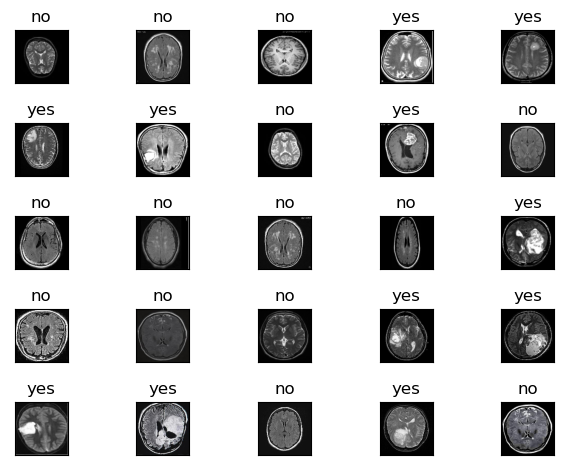

In [9]:
plot_images_5_5()

___

<b>plot_images_2_3</b> <i>(Function)</i>

<div style="text-align: justify">
The function loops through the first 6 images in the image list and creates a 2x3 grid of subplots using the subplot() function. It then displays the corresponding image in each subplot using the imshow() function from matplotlib. The title of each subplot is set to the corresponding category label using the title() function from matplotlib. The x and y ticks are removed from each subplot using the xticks() and yticks() functions from matplotlib.
    </div>

In [10]:
def plot_images_2_3():
    # Iterate over the range 0-5 (6 iterations)
    for i in range(6):
        # Create a subplot grid of 2 rows and 3 columns and select the i+1-th subplot
        plt.subplot(2, 3, i+1)
        
        # Display the image in the current subplot
        plt.imshow(image[i])
        
        # Set the title of the subplot to the corresponding label/category
        plt.title(categories[label[i]])
        
        # Remove the x-axis ticks
        plt.xticks([])
        
        # Remove the y-axis ticks
        plt.yticks([])

    # Display the plot
    plt.show()


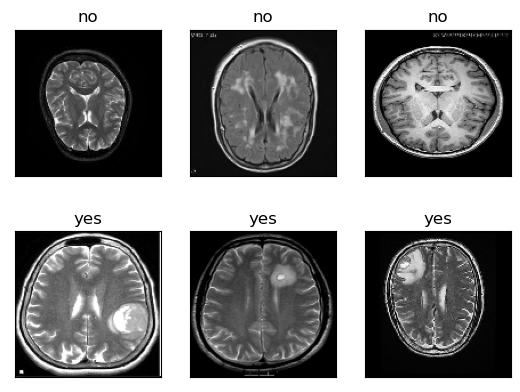

In [11]:
plot_images_2_3()

___

### <font size = '4'> <b> DISPLAY IMAGE BY IMAGE SIZE </b></font>

<div style="text-align: justify">
The code plots runs a for-loop displaying 3 images side by side comparing the different image size.
As it iterates through the loop, the IMG_SIZE will increase by 20, thus plotting images in sizes of 40, 60, 80.
<br>
<br>
A 3x3 version variant is made for visualizing better image classification. The code follows similar concepts but its tailored for its size, making it slighly unique.
    </div>

<b><i> <font color = 'purple'> (1 x 3) </font> </i></b>

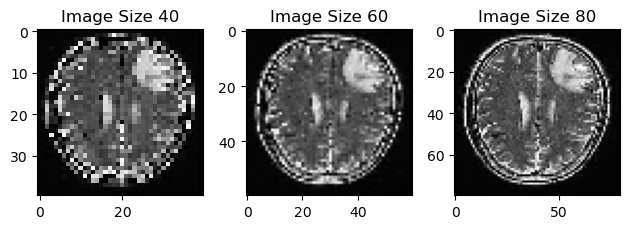

In [12]:
# Figure with 1 row and 3 columns for subplots
fig, axs = plt.subplots(1, 3)

# Directory path where the images are stored
directory = "data/"

# Categories or folders containing the images
categories = ["no", "yes"]

# Initial image size
IMG_SIZE = 40

# Loop through the subplots
for i in range(len(axs)):
    # Resize the image to the specified size
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    
    # Display the resized image in the current subplot as grayscale
    axs[i].imshow(new_array, cmap='gray')
    
    # Set the title for the current subplot
    axs[i].set_title(f'Image Size {IMG_SIZE}')
    
    # Increase the image size by 20 for the next iteration
    IMG_SIZE += 20

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


<b><i> <font color = 'purple'> (3 x 3) </font> </i></b>

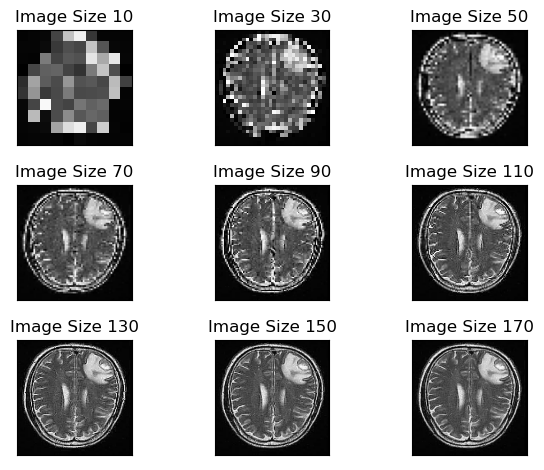

In [13]:
# Create a 3x3 grid of subplots
fig, axs = plt.subplots(3, 3)

# Initial image size
IMG_SIZE = 10

# Loop through the rows of subplots
for i in range(len(axs)):
    # Loop through the columns of subplots
    for j in range(len(axs)):
        # Resize the image to the specified size
        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        
        # Display the resized image in the current subplot as grayscale
        axs[i, j].imshow(new_array, cmap='gray')
        
        # Set the title for the current subplot
        axs[i, j].set_title(f'Image Size {IMG_SIZE}')
        
        # Increase the image size by 20 for the next iteration
        IMG_SIZE += 20

# Remove x-axis and y-axis ticks for all subplots
for ax in axs.flat:
    ax.set(xticks=[], yticks=[])

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

___

___

### Train Test Split

<div style="text-align: justify">
A Train Test Split is conducted by splitting the image array (containing the image) and the label array (containing the respective labels for the images) into training and validation data, with a 20% split, and random state of 42 to ensure the code will be ran the same way for consistency.
    </div>

In [7]:
#  Train Test Split function 
#  (can be found above in the "Functions (Tools) dropdown")

X_train, X_val, y_train, y_val = split_train_val_data(image, # Input
                                                        label, # Target
                                                        0.20,  # Percentage data allocation to validation
                                                        42)    # fixed random seed for reuseability 

<i><b><font color= 'red'> Train / Validation Size Check </font></b></i><br>
To make sure the model will run properly, a sanity check is necessary to ensure the train and validation sizes are the same for the model to run. If there is a imbalance of image size, then the model wont run, resulting in an error message.

In [8]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(2400, 128, 128, 3)
(2400,)
(600, 128, 128, 3)
(600,)


<b>Normalization</b>

As a common form of preprocessing images, we need to standardize the image to prevent any feature from receiving the most attention during the learning process. It also helps with model performance and stability.

In [9]:
X_train = normalize(X_train, axis =1)
X_val = normalize(X_val, axis =1)

___

### <b> Convolutionary Neural Network <i>(CNN)</i> Model </b>

#### <div style="text-align: center"><font color = 'red' size='5'><b>00 BASE MODEL</b></font></div>

In [30]:
# Instantiate
# base_model = Sequential()

In [36]:
def create_base_model():
    """
    Create the base model.

    Returns:
    - model: The base model with the defined architecture
    """

    # Create a Sequential model
    base_model = Sequential()

    # Add a 2D convolutional layer with 32 filters, each of size 3x3,
    # and input shape of (128, 128, 3) representing the image dimensions and color channels
    base_model.add(Conv2D(32, (3,3), input_shape=(128, 128, 3)))

    # Apply the ReLU activation function to introduce non-linearity
    base_model.add(Activation('relu'))

    # Add a max pooling layer with pool size of 2x2
    base_model.add(MaxPooling2D(pool_size=(2,2)))

    # Add another 2D convolutional layer with 32 filters, each of size 3x3,
    # and use the 'he_uniform' kernel initializer
    base_model.add(Conv2D(32, (3,3), kernel_initializer='he_uniform'))

    # Apply the ReLU activation function
    base_model.add(Activation('relu'))

    # Add another max pooling layer with pool size of 2x2
    base_model.add(MaxPooling2D(pool_size=(2,2)))

    # Add another 2D convolutional layer with 64 filters, each of size 3x3,
    # and use the 'he_uniform' kernel initializer
    base_model.add(Conv2D(64, (3,3), kernel_initializer='he_uniform'))

    # Apply the ReLU activation function
    base_model.add(Activation('relu'))

    # Add another max pooling layer with pool size of 2x2
    base_model.add(MaxPooling2D(pool_size=(2,2)))

    # Flatten the output of the previous layer to a 1D array
    base_model.add(Flatten())

    # Add a fully connected (dense) layer with 64 neurons
    base_model.add(Dense(64))

    # Apply the ReLU activation function
    base_model.add(Activation('relu'))

    # Apply dropout with a rate of 0.5 to prevent overfitting
    base_model.add(Dropout(0.5))

    # Add the output layer with a single neuron, using the sigmoid activation function
    base_model.add(Dense(1))
    base_model.add(Activation('sigmoid'))

    # Compile the model with binary cross-entropy loss function,
    # Adam optimizer, and accuracy as the metric to monitor
    base_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return base_model


___

<b><font color = 'red'> EXECUTE </font></b>

<div style="text-align: center"> <b> 100 Epoch </b> </div>

In [34]:
# Exexcute the model
base_results_100 = base_model.fit(X_train, y_train, batch_size = 16, 
          verbose=1, 
          epochs=100,
          validation_data= (X_val, y_val),
          shuffle = False)

# Save model
base_model.save('brain_tumor_base_100_epochs_16.h5')

___

<div style="text-align: center"> <b> 50 Epoch </b> </div>

In [40]:
# Exexcute the model
base_model = create_base_model()
base_results_50 = base_model.fit(X_train, y_train, batch_size = 16,
                                       verbose=1,
                                       epochs=50,
                                       validation_data=(X_val,y_val),
                                       shuffle=False)

# Save model
base_model.save('brain_tumor_base_50_epochs_16_batch.h5')

Epoch 1/50
150/150 [==============================] - 28s 181ms/step - loss: 0.4937 - accuracy: 0.7671 - val_loss: 0.3530 - val_accuracy: 0.8567
Epoch 2/50
150/150 [==============================] - 27s 182ms/step - loss: 0.3100 - accuracy: 0.8717 - val_loss: 0.2298 - val_accuracy: 0.9083
Epoch 3/50
150/150 [==============================] - 27s 183ms/step - loss: 0.2110 - accuracy: 0.9158 - val_loss: 0.1798 - val_accuracy: 0.9333
Epoch 4/50
150/150 [==============================] - 28s 185ms/step - loss: 0.1321 - accuracy: 0.9488 - val_loss: 0.1329 - val_accuracy: 0.9533
Epoch 5/50
150/150 [==============================] - 28s 185ms/step - loss: 0.0841 - accuracy: 0.9729 - val_loss: 0.0937 - val_accuracy: 0.9650
Epoch 6/50
150/150 [==============================] - 27s 180ms/step - loss: 0.0579 - accuracy: 0.9800 - val_loss: 0.1058 - val_accuracy: 0.9733
Epoch 7/50
150/150 [==============================] - 28s 185ms/step - loss: 0.0427 - accuracy: 0.9858 - val_loss: 0.1100 - val_ac

NameError: name 'model' is not defined

<div style="text-align: center"> <b> 20 Epoch </b> </div>

In [47]:
# Exexcute the model
base_model = create_base_model()
base_results_20 = base_model.fit(X_train, y_train, batch_size = 16, 
          verbose=1, 
          epochs=20,
          validation_data= (X_val, y_val),
          shuffle = False)

# Save model
base_model.save('brain_tumor_base_20_epochs_16_batch.h5')

Epoch 1/20
150/150 [==============================] - 25s 166ms/step - loss: 0.4847 - accuracy: 0.7679 - val_loss: 0.3741 - val_accuracy: 0.8533
Epoch 2/20
150/150 [==============================] - 25s 169ms/step - loss: 0.3150 - accuracy: 0.8704 - val_loss: 0.2372 - val_accuracy: 0.8967
Epoch 3/20
150/150 [==============================] - 25s 169ms/step - loss: 0.2142 - accuracy: 0.9133 - val_loss: 0.1506 - val_accuracy: 0.9367
Epoch 4/20
150/150 [==============================] - 25s 170ms/step - loss: 0.1351 - accuracy: 0.9504 - val_loss: 0.1149 - val_accuracy: 0.9583
Epoch 5/20
150/150 [==============================] - 26s 171ms/step - loss: 0.0799 - accuracy: 0.9758 - val_loss: 0.1274 - val_accuracy: 0.9467
Epoch 6/20
150/150 [==============================] - 26s 171ms/step - loss: 0.0609 - accuracy: 0.9808 - val_loss: 0.0927 - val_accuracy: 0.9700
Epoch 7/20
150/150 [==============================] - 26s 170ms/step - loss: 0.0331 - accuracy: 0.9917 - val_loss: 0.0911 - val_ac

___

<b><font color = 'red'> PLOT RESULTS </font></b>

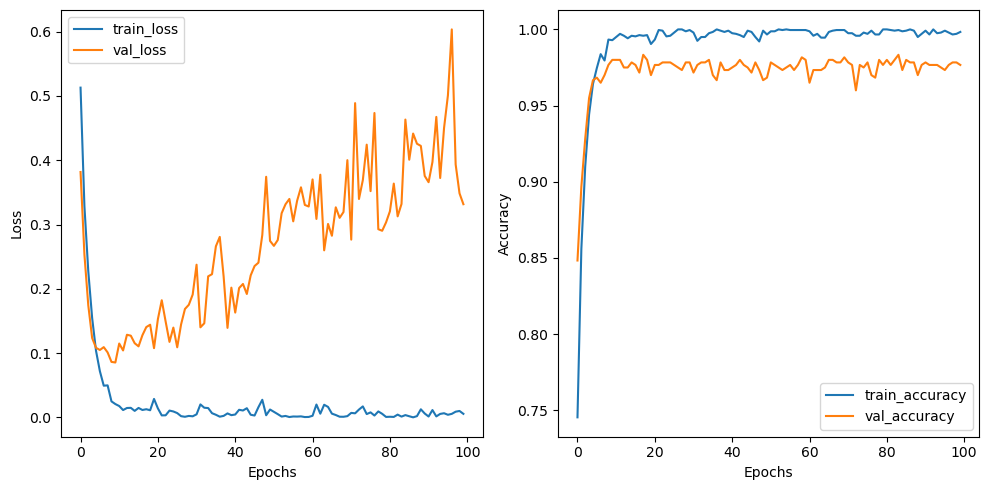

19/19 [==============================] - 2s 75ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       310
           1       0.99      0.97      0.98       290

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 activation_35 (Activation)  (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 co

In [43]:
#Plot Results - 100 Epoch | 16 batch
plot_training_results(base_results_100, base_model)

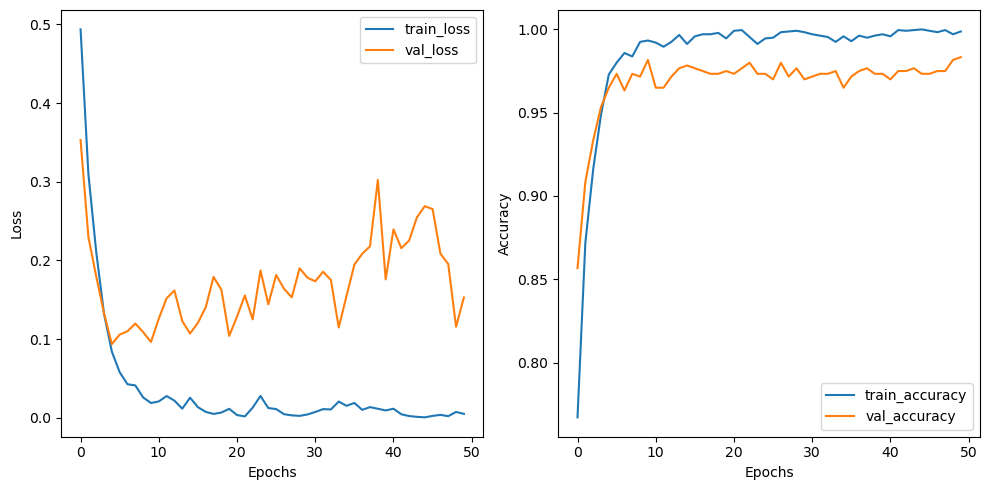

19/19 [==============================] - 1s 76ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       310
           1       0.99      0.97      0.98       290

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 activation_35 (Activation)  (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 co

In [44]:
#Plot Results - 50 Epoch | 16 batch
plot_training_results(base_results_50, base_model)

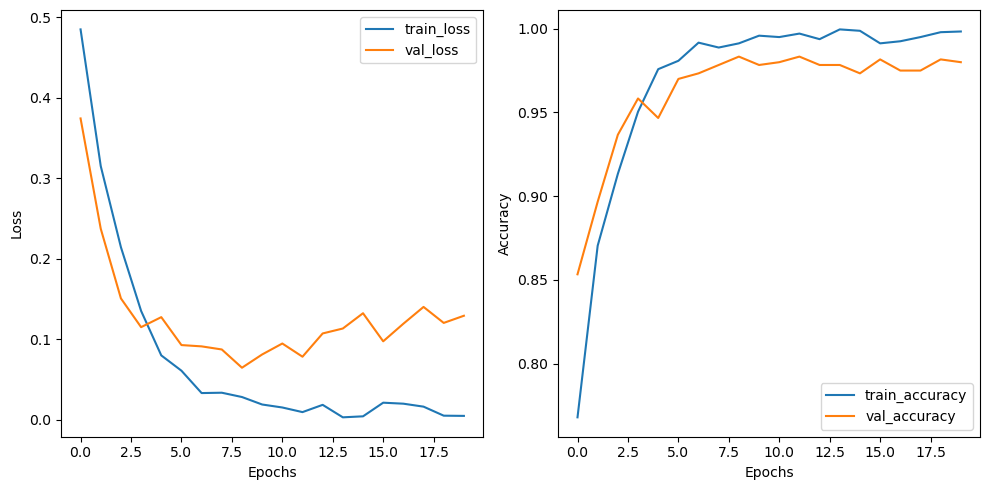

19/19 [==============================] - 1s 72ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       310
           1       0.98      0.98      0.98       290

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 activation_40 (Activation)  (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 co

In [48]:
#Plot Results - 20 Epoch | 16 batch
plot_training_results(base_results_20, base_model)

___

<font color = 'red'><i><u>Classification Report</u></i></font>

In [49]:
# Use the trained model to predict probabilities for the test data
y_pred_prob = base_model.predict(X_val)

# Convert probabilities to class labels based on a threshold
threshold = 0.5
y_pred = (y_pred_prob > threshold).astype(int)
# print(y_pred)

# Print the classification report
print(classification_report(y_val, y_pred, zero_division=1))

19/19 [==============================] - 1s 72ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       310
           1       0.98      0.98      0.98       290

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600



___

<font color = 'red'><i><u> Model Summary</u></i></font>

In [50]:
base_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 activation_40 (Activation)  (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 61, 61, 32)        9248      
                                                                 
 activation_41 (Activation)  (None, 61, 61, 32)        0         
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 30, 30, 32)       0         
 g2D)                                                 

___

<b><font color = 'orange' size='4'> EVALUATION </font><b>

<b><font color = 'green'> 100 epochs </font></b><br>

<div style="text-align: justify">
According to the train loss vs the val loss, the data seems ideally going well at around 7 epochs, then converges. But before I consider the possibility of overfitting, batch size will be the first parameter to tweak as a low batch size renders less memory but takes more time, leading to better generalization.<br>
<br>
When considering the Classification Report, it seems like the model might be running perfect at 99% across the board. To account for the loss variance and volatility, regularization is an option to consider, augmenting the data, or hyperparameter tuning.<br>
    
<b><font color = 'green'> 50 epochs </font></b><br>
Running the model at 50 epochs is an amplified version of 100 epochs. Its clearly evident the model is converging as the val losses and val accuracy going into unfavorable direction at a given point. (val loss > train loss) (val accuracy < train accuracy)

<b><font color = 'green'> 20 epochs </font></b><br>
At 20 epochs, I can see the model is doing fairly well as the lines are smoothened out. It seems as if the validation data is not performing as well, which will require some adjustments to the model.
</div>

___

<b><font color = FF72FB size='4'> Improvements </font></b> <i>(To be made)</i>

<b> Code </b>
<ul>
    <li> When writing the code for the plot, classification report, and model summary, its best to combine all codes into one function so that after the model is done running, the information is properly displayed for that point in time the model ran. </li>
    <li>Making a function for the model will be considered to avoid redundency.</li>
</ul>

<b> Model </b>
<ul>
    <li> Improve model by changing the parameters</li>
    <li>Consider the possibility of overfitting</li>
    <li><i>TBD after the above was considered</i></li>
</ul>

#### <div style="text-align: center"><font color = 'red' size='5'><b>01 HYPERPARAMETER TUNING</b></font></div>

<div style="text-align: justify">
As for improvements to the model and functionality, I decided to create a cell for tuning parameters. Its made easy to adjust batch size, epoch, learning rate, and augmentation in one simple cell. This helps with consistency and easy-to-use tuning.<br><br>
For this portion of tuning, different epoch levels will be evaluated to determine what epoch should be considered moving forward so the tuning parameters wont be much of use, but will be referenced upon determination.
    </div>

<i>Tuning Paramenters</i>

In [58]:
##############(Image Size)###############
IMG_SIZE = 128

#########################################


##############(Batch Size)###############
batch_size = 32

#########################################


################(Epoch)##################
epoch = 30

#########################################


###########(Exponential Decay)###########
# Learning rate schedule parameters
initial_lr = 0.001
decay_steps = 1000
decay_rate = 0.96
#########################################


############(ImageGenerator)############
# Parameters used in ImageGenerator
rotation_range=20
width_shift_range=0.2
height_shift_range=0.2
shear_range=0.2
zoom_range=0.2
horizontal_flip=True
fill_mode='nearest'
#########################################

##### <div style="text-align: left"><font color = 'purple' size='5'><b>Ver 1 - ADJUST EPOCH</b></font></div>

<i>Instantiate</i>

In [60]:
#Instantiate model
model1 = Sequential()

<i>Compile</i>

In [65]:
def create_model1():
    """
    Create Model 1

    Returns:
    - model: Model 1 with the defined architecture
    """

    # Create a Sequential model
    model1 = Sequential()

    # Add a 2D convolutional layer with 32 filters, each of size 3x3,
    # and input shape of (IMG_SIZE, IMG_SIZE, 3) representing the image dimensions and color channels
    model1.add(Conv2D(32, (3,3), input_shape=(IMG_SIZE, IMG_SIZE, 3)))

    # Apply the ReLU activation function
    model1.add(Activation('relu'))

    # Add a max pooling layer with pool size of 2x2
    model1.add(MaxPooling2D(pool_size=(2,2)))

    # Add another 2D convolutional layer with 32 filters, each of size 3x3,
    # and use the 'he_uniform' kernel initializer
    model1.add(Conv2D(32, (3,3), kernel_initializer='he_uniform'))

    # Apply the ReLU activation function
    model1.add(Activation('relu'))

    # Add another max pooling layer with pool size of 2x2
    model1.add(MaxPooling2D(pool_size=(2,2)))

    # Add another 2D convolutional layer with 64 filters, each of size 3x3,
    # and use the 'he_uniform' kernel initializer
    model1.add(Conv2D(64, (3,3), kernel_initializer='he_uniform'))

    # Apply the ReLU activation function
    model1.add(Activation('relu'))

    # Add another max pooling layer with pool size of 2x2
    model1.add(MaxPooling2D(pool_size=(2,2)))

    # Flatten the output of the previous layer to a 1D array
    model1.add(Flatten())

    # Add a fully connected (dense) layer with 64 neurons
    model1.add(Dense(64))

    # Apply the ReLU activation function
    model1.add(Activation('relu'))

    # Apply dropout with a rate of 0.5 to prevent overfitting
    model1.add(Dropout(0.5))

    # Add the output layer with a single neuron, using the sigmoid activation function
    model1.add(Dense(1))
    model1.add(Activation('sigmoid'))

    # Compile the model with binary cross-entropy loss function,
    # Adam optimizer, and accuracy as the metric to monitor
    model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model1


################################################################################
################################################################################

<b><font color = 'red'> EXECUTE </font></b>

<div style="text-align: center"> <b> 100 Epoch </b> <i>at 32 batch</i> </div> 

In [62]:
# Exexcute the model
results100 = model1.fit(X_train, y_train, batch_size = 32, 
          verbose=1, 
          epochs=100,
          validation_data= (X_val, y_val),
          shuffle = False)

# Save model
model1.save('model/brain_tumor_ver1_100_epochs_32.h5')

Epoch 1/100
75/75 [==============================] - 24s 318ms/step - loss: 0.5150 - accuracy: 0.7421 - val_loss: 0.4294 - val_accuracy: 0.8150
Epoch 2/100
75/75 [==============================] - 24s 321ms/step - loss: 0.3557 - accuracy: 0.8471 - val_loss: 0.2506 - val_accuracy: 0.8950
Epoch 3/100
75/75 [==============================] - 25s 327ms/step - loss: 0.2333 - accuracy: 0.9054 - val_loss: 0.1996 - val_accuracy: 0.9133
Epoch 4/100
75/75 [==============================] - 24s 318ms/step - loss: 0.1769 - accuracy: 0.9317 - val_loss: 0.1928 - val_accuracy: 0.9200
Epoch 5/100
75/75 [==============================] - 24s 321ms/step - loss: 0.1178 - accuracy: 0.9592 - val_loss: 0.1296 - val_accuracy: 0.9500
Epoch 6/100
75/75 [==============================] - 24s 322ms/step - loss: 0.0955 - accuracy: 0.9638 - val_loss: 0.1205 - val_accuracy: 0.9550
Epoch 7/100
75/75 [==============================] - 24s 322ms/step - loss: 0.0678 - accuracy: 0.9792 - val_loss: 0.0921 - val_accuracy:

75/75 [==============================] - 24s 322ms/step - loss: 0.0053 - accuracy: 0.9975 - val_loss: 0.1434 - val_accuracy: 0.9750
Epoch 58/100
75/75 [==============================] - 24s 319ms/step - loss: 0.0102 - accuracy: 0.9975 - val_loss: 0.1451 - val_accuracy: 0.9767
Epoch 59/100
75/75 [==============================] - 24s 318ms/step - loss: 0.0043 - accuracy: 0.9987 - val_loss: 0.1811 - val_accuracy: 0.9700
Epoch 60/100
75/75 [==============================] - 24s 318ms/step - loss: 0.0062 - accuracy: 0.9971 - val_loss: 0.1548 - val_accuracy: 0.9750
Epoch 61/100
75/75 [==============================] - 24s 319ms/step - loss: 0.0023 - accuracy: 0.9996 - val_loss: 0.1416 - val_accuracy: 0.9783
Epoch 62/100
75/75 [==============================] - 24s 322ms/step - loss: 4.0992e-04 - accuracy: 1.0000 - val_loss: 0.1641 - val_accuracy: 0.9767
Epoch 63/100
75/75 [==============================] - 24s 321ms/step - loss: 6.7663e-04 - accuracy: 0.9996 - val_loss: 0.1594 - val_accurac

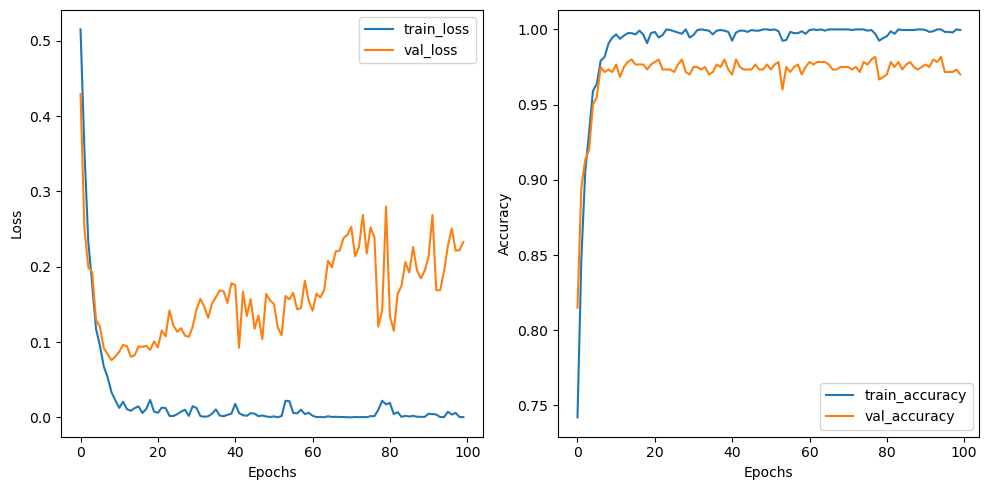

19/19 [==============================] - 1s 73ms/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       310
           1       0.97      0.97      0.97       290

    accuracy                           0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 activation_55 (Activation)  (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 c

In [64]:
plot_training_results(results100, model1)

As you can see, when adjusting the batch size, we were able to reduce the convergence gap between loss and accuracy charts. <br>

Lets try to run the model at 64 batch, and see if it will help improve closing the convergence gap.

<div style="text-align: center"> <b> 100 Epoch </b> <i>at <font color = 'red'>64</font> batch</i> </div> 

In [66]:
# Exexcute the model
model1 = create_model1()
results100_64 = model1.fit(X_train, y_train, batch_size = 64, 
          verbose=1, 
          epochs=100,
          validation_data= (X_val, y_val),
          shuffle = False)

# Save model
model1.save('model/brain_tumor_ver1_100_epochs_64.h5')

Epoch 1/100
38/38 [==============================] - 24s 615ms/step - loss: 0.5318 - accuracy: 0.7300 - val_loss: 0.4478 - val_accuracy: 0.7800
Epoch 2/100
38/38 [==============================] - 24s 624ms/step - loss: 0.4053 - accuracy: 0.8200 - val_loss: 0.3110 - val_accuracy: 0.8600
Epoch 3/100
38/38 [==============================] - 23s 617ms/step - loss: 0.2908 - accuracy: 0.8792 - val_loss: 0.2389 - val_accuracy: 0.8950
Epoch 4/100
38/38 [==============================] - 24s 621ms/step - loss: 0.2306 - accuracy: 0.9083 - val_loss: 0.2002 - val_accuracy: 0.9267
Epoch 5/100
38/38 [==============================] - 24s 624ms/step - loss: 0.1732 - accuracy: 0.9350 - val_loss: 0.1605 - val_accuracy: 0.9433
Epoch 6/100
38/38 [==============================] - 24s 621ms/step - loss: 0.1238 - accuracy: 0.9596 - val_loss: 0.1488 - val_accuracy: 0.9533
Epoch 7/100
38/38 [==============================] - 24s 621ms/step - loss: 0.0886 - accuracy: 0.9708 - val_loss: 0.1150 - val_accuracy:

38/38 [==============================] - 26s 687ms/step - loss: 0.0022 - accuracy: 0.9996 - val_loss: 0.1078 - val_accuracy: 0.9783
Epoch 58/100
38/38 [==============================] - 26s 684ms/step - loss: 3.7600e-04 - accuracy: 1.0000 - val_loss: 0.1288 - val_accuracy: 0.9800
Epoch 59/100
38/38 [==============================] - 26s 680ms/step - loss: 8.2921e-04 - accuracy: 0.9996 - val_loss: 0.1232 - val_accuracy: 0.9783
Epoch 60/100
38/38 [==============================] - 26s 687ms/step - loss: 9.9065e-04 - accuracy: 0.9996 - val_loss: 0.1373 - val_accuracy: 0.9783
Epoch 61/100
38/38 [==============================] - 26s 677ms/step - loss: 0.0030 - accuracy: 0.9992 - val_loss: 0.1145 - val_accuracy: 0.9767
Epoch 62/100
38/38 [==============================] - 25s 656ms/step - loss: 0.0031 - accuracy: 0.9996 - val_loss: 0.1530 - val_accuracy: 0.9750
Epoch 63/100
38/38 [==============================] - 25s 660ms/step - loss: 3.6971e-04 - accuracy: 1.0000 - val_loss: 0.1348 - val

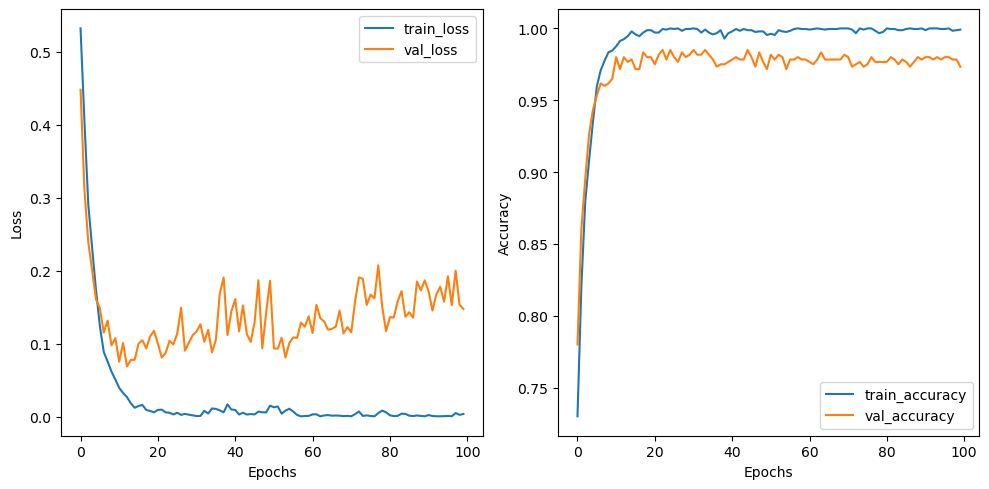

19/19 [==============================] - 1s 75ms/step
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       310
           1       0.98      0.97      0.97       290

    accuracy                           0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 activation_60 (Activation)  (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 c

In [67]:
plot_training_results(results100_64, model1)

Making the batch 64 did help smoothen out the accuracy and loss, but made the validation accuracy and loss a bit more volatile. Next step is to regularize the model to reduce sudden jumps in validation loss and accuracy.

___

##### <div style="text-align: left"><font color = 'purple' size='5'><b>Ver 2 - ADD REGULARIZATION</b></font></div>

<div style="text-align: justify">
Regularization techniques, such as L2 regularization, play a crucial role in managing the complexity of a model and enhancing its generalization capabilities by mitigating overfitting. L2 regularization achieves this by imposing a penalty on large weight values within the model. By penalizing these weights, L2 regularization encourages the model to prioritize robust and significant patterns in the data. Consequently, the model becomes less likely to rely on noise or irrelevant features, resulting in improved performance when presented with new, unseen data.
    </div>

<i>Instantiate</i>

In [21]:
# #Instantiate model
# model = Sequential()

<i>Compile</i>

In [69]:
def create_model2():

    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=(IMG_SIZE, IMG_SIZE, 3), kernel_regularizer=l2(0.001)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3), kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))


    # Flatten the output of the previous layer to a 1D array
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))


    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model
################################################################################
################################################################################

<i> Execute </i>

<div style="text-align: center"> <b> 100 Epoch </b> <i>at <font color = 'red'>64</font> batch</i> with <i><font color = 'green'> Regularizer </font></i> </div> 

In [72]:
# Exexcute the model
model2 = create_model2()
results100_64_ver2 = model2.fit(X_train, y_train, batch_size = 64, 
          verbose=1, 
          epochs=100,
          validation_data= (X_val, y_val),
          shuffle = False)

# Save model
model2.save('model/brain_tumor_ver2_100_epochs_64_reg.h5')

Epoch 1/100
38/38 [==============================] - 24s 605ms/step - loss: 0.6894 - accuracy: 0.7312 - val_loss: 0.5867 - val_accuracy: 0.8100
Epoch 2/100
38/38 [==============================] - 23s 616ms/step - loss: 0.5313 - accuracy: 0.8183 - val_loss: 0.4759 - val_accuracy: 0.8500
Epoch 3/100
38/38 [==============================] - 24s 620ms/step - loss: 0.4134 - accuracy: 0.8788 - val_loss: 0.3962 - val_accuracy: 0.8883
Epoch 4/100
38/38 [==============================] - 24s 622ms/step - loss: 0.3448 - accuracy: 0.9071 - val_loss: 0.3628 - val_accuracy: 0.8933
Epoch 5/100
38/38 [==============================] - 23s 616ms/step - loss: 0.3210 - accuracy: 0.9146 - val_loss: 0.2983 - val_accuracy: 0.9350
Epoch 6/100
38/38 [==============================] - 24s 623ms/step - loss: 0.2621 - accuracy: 0.9400 - val_loss: 0.2764 - val_accuracy: 0.9433
Epoch 7/100
38/38 [==============================] - 24s 624ms/step - loss: 0.2333 - accuracy: 0.9538 - val_loss: 0.2485 - val_accuracy:

38/38 [==============================] - 24s 627ms/step - loss: 0.0322 - accuracy: 0.9979 - val_loss: 0.1155 - val_accuracy: 0.9817
Epoch 58/100
38/38 [==============================] - 24s 632ms/step - loss: 0.0350 - accuracy: 0.9971 - val_loss: 0.1265 - val_accuracy: 0.9767
Epoch 59/100
38/38 [==============================] - 24s 626ms/step - loss: 0.0343 - accuracy: 0.9958 - val_loss: 0.1095 - val_accuracy: 0.9833
Epoch 60/100
38/38 [==============================] - 24s 623ms/step - loss: 0.0299 - accuracy: 0.9992 - val_loss: 0.1198 - val_accuracy: 0.9800
Epoch 61/100
38/38 [==============================] - 24s 628ms/step - loss: 0.0267 - accuracy: 1.0000 - val_loss: 0.1103 - val_accuracy: 0.9850
Epoch 62/100
38/38 [==============================] - 24s 625ms/step - loss: 0.0242 - accuracy: 1.0000 - val_loss: 0.1130 - val_accuracy: 0.9817
Epoch 63/100
38/38 [==============================] - 24s 626ms/step - loss: 0.0319 - accuracy: 0.9967 - val_loss: 0.1025 - val_accuracy: 0.975

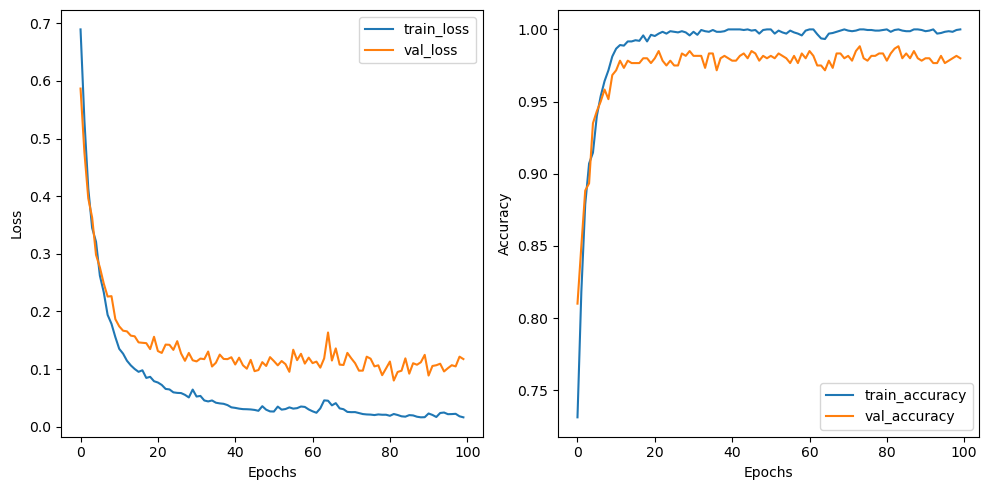

19/19 [==============================] - 1s 72ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       310
           1       0.98      0.98      0.98       290

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 activation_70 (Activation)  (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 c

In [74]:
plot_training_results(results100_64_ver2, model2)

<div style="text-align: justify">
Although the gap has closed up a bit, it made the training loss and accuracy more volatile, resulting to be ineffective. To test the waters, data augmentation will be added into the model.  This will artificially increase the data size and add more diversity to the dataset with hopes to reduce overfitting and add more generalization to close the gap and reduce volatility.
    </div>

___

##### <div style="text-align: left"><font color = 'purple' size='5'><b>Ver 3 - ADD DATA AUGMENTATION</b></font></div>

<i>Instantiate</i>

In [32]:
#Instantiate model
model = Sequential()

<i>Compile</i>

In [80]:
def create_model3():
    
    #Instantiate model
    model = Sequential()

    # Create an instance of the ImageDataGenerator with desired augmentation parameters
    datagen = ImageDataGenerator(
        rotation_range=rotation_range,  # Randomly rotate images by 10 degrees
        width_shift_range=width_shift_range,  # Randomly shift images horizontally by 10% of the total width
        height_shift_range=height_shift_range,  # Randomly shift images vertically by 10% of the total height
        zoom_range=zoom_range,  # Randomly zoom images by 10%
        horizontal_flip=horizontal_flip  # Randomly flip images horizontally
    )

    # Apply data augmentation to the training data generator
    train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)

    # Define and compile your model
    model = Sequential()
    model.add(Conv2D(32, (3,3), input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(32, (3,3), kernel_initializer='he_uniform'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(64, (3,3), kernel_initializer='he_uniform'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model, train_generator

<div style="text-align: center"> <b> 100 Epoch </b> <i>at <font color = 'red'>64</font> batch</i> with <i><font color = 'blue'> Augmentation </font></i> </div> 

In [81]:
# Exexcute the model
# Train the model using the augmented data generator
model3, train_generator = create_model3()
results100_augmented = model3.fit(train_generator, epochs=100, validation_data=(X_val, y_val))

# Save model
model.save('model/brain_tumor_ver3_100_epochs_64_aug.h5')

Epoch 1/100
75/75 [==============================] - 26s 343ms/step - loss: 0.6673 - accuracy: 0.5933 - val_loss: 0.5517 - val_accuracy: 0.7100
Epoch 2/100
75/75 [==============================] - 27s 362ms/step - loss: 0.6331 - accuracy: 0.6417 - val_loss: 0.5571 - val_accuracy: 0.7467
Epoch 3/100
75/75 [==============================] - 27s 363ms/step - loss: 0.6099 - accuracy: 0.6733 - val_loss: 0.5320 - val_accuracy: 0.7617
Epoch 4/100
75/75 [==============================] - 27s 355ms/step - loss: 0.5951 - accuracy: 0.6862 - val_loss: 0.4722 - val_accuracy: 0.7917
Epoch 5/100
75/75 [==============================] - 27s 359ms/step - loss: 0.5853 - accuracy: 0.7017 - val_loss: 0.4772 - val_accuracy: 0.7983
Epoch 6/100
75/75 [==============================] - 27s 359ms/step - loss: 0.5594 - accuracy: 0.7267 - val_loss: 0.4276 - val_accuracy: 0.8033
Epoch 7/100
75/75 [==============================] - 27s 362ms/step - loss: 0.5492 - accuracy: 0.7262 - val_loss: 0.5086 - val_accuracy:

75/75 [==============================] - 28s 368ms/step - loss: 0.1868 - accuracy: 0.9312 - val_loss: 0.1517 - val_accuracy: 0.9383
Epoch 58/100
75/75 [==============================] - 27s 360ms/step - loss: 0.1572 - accuracy: 0.9442 - val_loss: 0.1500 - val_accuracy: 0.9400
Epoch 59/100
75/75 [==============================] - 27s 361ms/step - loss: 0.1457 - accuracy: 0.9504 - val_loss: 0.1499 - val_accuracy: 0.9500
Epoch 60/100
75/75 [==============================] - 27s 366ms/step - loss: 0.1658 - accuracy: 0.9383 - val_loss: 0.1157 - val_accuracy: 0.9667
Epoch 61/100
75/75 [==============================] - 27s 360ms/step - loss: 0.1470 - accuracy: 0.9421 - val_loss: 0.2134 - val_accuracy: 0.9217
Epoch 62/100
75/75 [==============================] - 28s 370ms/step - loss: 0.1450 - accuracy: 0.9471 - val_loss: 0.1281 - val_accuracy: 0.9517
Epoch 63/100
75/75 [==============================] - 27s 364ms/step - loss: 0.1514 - accuracy: 0.9417 - val_loss: 0.1192 - val_accuracy: 0.953

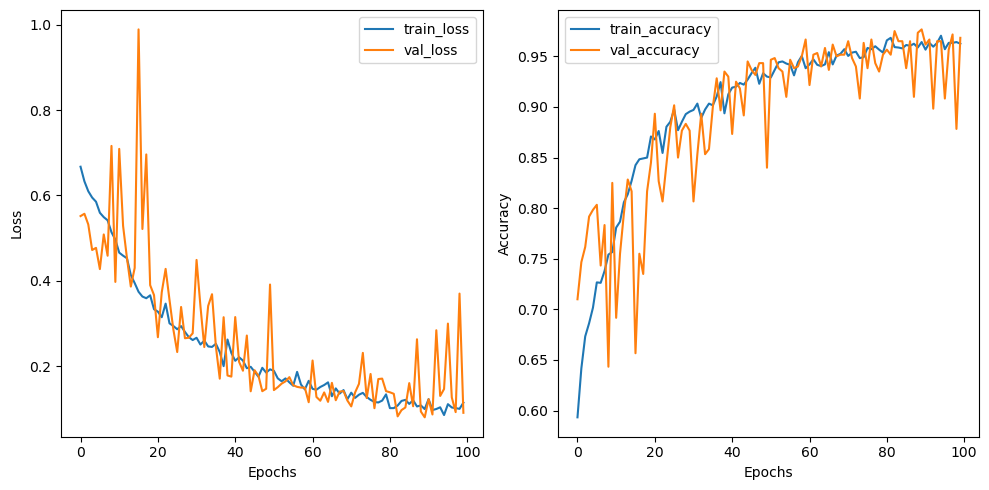

19/19 [==============================] - 2s 76ms/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       310
           1       0.97      0.97      0.97       290

    accuracy                           0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 activation_85 (Activation)  (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 c

In [83]:
plot_training_results(results100_augmented, model3)

Adding the augmentation and removing the regularizer made matters worse. The model will be ran with both augmentation and regularizer to see if they tend to balance out.

##### <div style="text-align: left"><font color = 'purple' size='5'><b>Ver 4 - DATA AUGMENTATION</b></font> <b>with <i>Regularization</i></b></div>

<i>Instantiate</i>

In [36]:
# #Instantiate model
# model = Sequential()

<i>Compile</i>

In [87]:
def create_model4():
    
    model = Sequential()
    
    # Create an instance of the ImageDataGenerator with desired augmentation parameters
    datagen = ImageDataGenerator(
        rotation_range=rotation_range,  # Randomly rotate images by 10 degrees
        width_shift_range=width_shift_range,  # Randomly shift images horizontally by 10% of the total width
        height_shift_range=height_shift_range,  # Randomly shift images vertically by 10% of the total height
        zoom_range=zoom_range,  # Randomly zoom images by 10%
        horizontal_flip=horizontal_flip  # Randomly flip images horizontally
    )

    # Apply data augmentation to the training data generator
    train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)

    # Define and compile your model
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(IMG_SIZE, IMG_SIZE, 3), kernel_regularizer=l2(0.001)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(32, (3,3), kernel_initializer='he_uniform'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(64, (3,3), kernel_initializer='he_uniform'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

<div style="text-align: center"> <b> 100 Epoch </b> <i>at <font color = 'red'>64</font> batch</i> with <i><font color = 'blue'> Augmentation </font></i> and <font color='green'><i>Regularization</i></font> </div> 

In [88]:
# Exexcute the model
# Train the model using the augmented data generator
model4 = create_model4()
results100_augmented = model4.fit(train_generator, epochs=100, validation_data=(X_val, y_val))

# Save model
model4.save('model/brain_tumor_ver4_100_epochs_64_aug_reg.h5')

Epoch 1/100
75/75 [==============================] - 52s 688ms/step - loss: 0.6863 - accuracy: 0.5642 - val_loss: 0.6852 - val_accuracy: 0.5350
Epoch 2/100
75/75 [==============================] - 49s 648ms/step - loss: 0.6341 - accuracy: 0.6471 - val_loss: 0.6802 - val_accuracy: 0.5533
Epoch 3/100
75/75 [==============================] - 52s 694ms/step - loss: 0.6162 - accuracy: 0.6733 - val_loss: 0.6165 - val_accuracy: 0.6433
Epoch 4/100
75/75 [==============================] - 54s 723ms/step - loss: 0.6051 - accuracy: 0.6783 - val_loss: 0.5635 - val_accuracy: 0.7133
Epoch 5/100
75/75 [==============================] - 50s 665ms/step - loss: 0.5823 - accuracy: 0.6979 - val_loss: 0.5170 - val_accuracy: 0.7650
Epoch 6/100
75/75 [==============================] - 50s 665ms/step - loss: 0.5708 - accuracy: 0.7212 - val_loss: 0.4800 - val_accuracy: 0.7933
Epoch 7/100
75/75 [==============================] - 55s 737ms/step - loss: 0.5598 - accuracy: 0.7279 - val_loss: 0.4275 - val_accuracy:

75/75 [==============================] - 28s 378ms/step - loss: 0.1821 - accuracy: 0.9400 - val_loss: 0.1753 - val_accuracy: 0.9333
Epoch 58/100
75/75 [==============================] - 29s 383ms/step - loss: 0.1638 - accuracy: 0.9408 - val_loss: 0.2514 - val_accuracy: 0.9183
Epoch 59/100
75/75 [==============================] - 29s 384ms/step - loss: 0.1943 - accuracy: 0.9296 - val_loss: 0.1621 - val_accuracy: 0.9500
Epoch 60/100
75/75 [==============================] - 29s 383ms/step - loss: 0.1600 - accuracy: 0.9475 - val_loss: 0.2282 - val_accuracy: 0.9133
Epoch 61/100
75/75 [==============================] - 29s 382ms/step - loss: 0.1715 - accuracy: 0.9400 - val_loss: 0.1448 - val_accuracy: 0.9500
Epoch 62/100
75/75 [==============================] - 29s 384ms/step - loss: 0.1711 - accuracy: 0.9337 - val_loss: 0.2201 - val_accuracy: 0.9183
Epoch 63/100
75/75 [==============================] - 29s 390ms/step - loss: 0.1601 - accuracy: 0.9463 - val_loss: 0.2401 - val_accuracy: 0.923

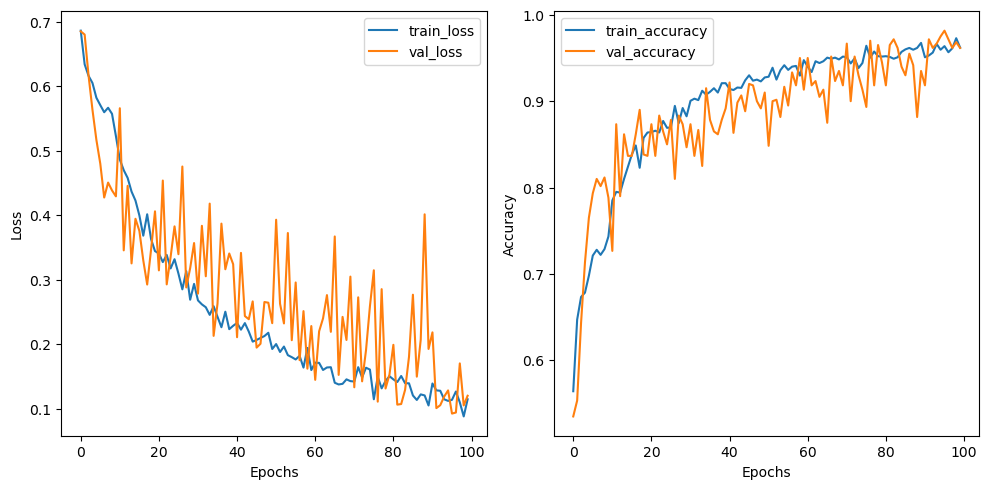

19/19 [==============================] - 4s 208ms/step
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       310
           1       0.94      0.98      0.96       290

    accuracy                           0.96       600
   macro avg       0.96      0.96      0.96       600
weighted avg       0.96      0.96      0.96       600

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 activation_90 (Activation)  (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 

In [90]:
plot_training_results(results100_augmented, model4)

In [106]:
test_loss, test_acc = model4.evaluate(X_val, y_val)
model_acc_loss(test_acc, test_loss)

19/19 [==============================] - 2s 78ms/step - loss: 0.1201 - accuracy: 0.9617
Model Accuracy (Test data)
________________________________________

Model Accuracy:       0.9616666436195374
Test Loss:           0.12013471126556396
________________________________________



Adding the Regularizer and the data augmentation parameters didnt really help much but it tended to create more spikes. To combat this, a learning scheduler will be applied to see if it can reduce the learning rate, and help reduce volatility.

___

##### <div style="text-align: left"><font color = 'purple' size='5'><b>Ver 5 - ADD LEARNING RATE SCHEDULER</b></font> <b>with <i>Regularization & Augmentation</i></b></div>

<i>Instantiate</i>

In [50]:
#Instantiate model
model = Sequential()

<i>Compile</i>

In [102]:
def create_model5():

    #Instantiate model
    model = Sequential()
    
    # Create an instance of the ImageDataGenerator with desired augmentation parameters
    datagen = ImageDataGenerator(
        rotation_range=rotation_range,  # Randomly rotate images by 10 degrees
        width_shift_range=width_shift_range,  # Randomly shift images horizontally by 10% of the total width
        height_shift_range=height_shift_range,  # Randomly shift images vertically by 10% of the total height
        zoom_range=zoom_range,  # Randomly zoom images by 10%
        horizontal_flip=horizontal_flip  # Randomly flip images horizontally
    )

    # Apply data augmentation to the training data generator
    train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)

    # Define and compile your model
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(IMG_SIZE, IMG_SIZE, 3), kernel_regularizer=l2(0.001)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(32, (3,3), kernel_initializer='he_uniform'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(64, (3,3), kernel_initializer='he_uniform'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Define the learning rate scheduler callback
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)

    
    return model, lr_scheduler, train_generator


<div style="text-align: center"> <b> 100 Epoch (LR_Scheduler)</b> <i>at <font color = 'red'>64</font> batch</i> with <i><font color = 'blue'> Augmentation </font></i> and <font color='green'><i>Regularization</i></font> </div> 

In [104]:
# Exexcute the model
# Train the model with the learning rate scheduler
model5, lr_scheduler, train_generator = create_model5()
results100_ver5 = model5.fit(train_generator, epochs=100, validation_data=(X_val, y_val), callbacks=[lr_scheduler])

# Save model
model5.save('model/brain_tumor_ver5_100_epochs_64_aug_reg_LR_sched.h5')

Epoch 1/100
75/75 [==============================] - 52s 686ms/step - loss: 0.6751 - accuracy: 0.5875 - val_loss: 0.6493 - val_accuracy: 0.6033 - lr: 0.0010
Epoch 2/100
75/75 [==============================] - 51s 676ms/step - loss: 0.6377 - accuracy: 0.6400 - val_loss: 0.6188 - val_accuracy: 0.6383 - lr: 0.0010
Epoch 3/100
75/75 [==============================] - 51s 674ms/step - loss: 0.6171 - accuracy: 0.6654 - val_loss: 0.5981 - val_accuracy: 0.6783 - lr: 0.0010
Epoch 4/100
75/75 [==============================] - 57s 754ms/step - loss: 0.5950 - accuracy: 0.6933 - val_loss: 0.5465 - val_accuracy: 0.7317 - lr: 0.0010
Epoch 5/100
75/75 [==============================] - 54s 724ms/step - loss: 0.5823 - accuracy: 0.6988 - val_loss: 0.5214 - val_accuracy: 0.7700 - lr: 0.0010
Epoch 6/100
75/75 [==============================] - 53s 701ms/step - loss: 0.5623 - accuracy: 0.7217 - val_loss: 0.5789 - val_accuracy: 0.7167 - lr: 0.0010
Epoch 7/100
75/75 [==============================] - 58s 7

75/75 [==============================] - 27s 362ms/step - loss: 0.2113 - accuracy: 0.9208 - val_loss: 0.2725 - val_accuracy: 0.8750 - lr: 1.0000e-07
Epoch 49/100
75/75 [==============================] - 27s 362ms/step - loss: 0.2056 - accuracy: 0.9287 - val_loss: 0.2725 - val_accuracy: 0.8750 - lr: 1.0000e-07
Epoch 50/100
75/75 [==============================] - 28s 366ms/step - loss: 0.2204 - accuracy: 0.9183 - val_loss: 0.2724 - val_accuracy: 0.8750 - lr: 1.0000e-07
Epoch 51/100
75/75 [==============================] - 27s 363ms/step - loss: 0.2142 - accuracy: 0.9204 - val_loss: 0.2722 - val_accuracy: 0.8733 - lr: 1.0000e-07
Epoch 52/100
75/75 [==============================] - ETA: 0s - loss: 0.2075 - accuracy: 0.9250
Epoch 52: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
75/75 [==============================] - 28s 370ms/step - loss: 0.2075 - accuracy: 0.9250 - val_loss: 0.2723 - val_accuracy: 0.8733 - lr: 1.0000e-07
Epoch 53/100
75/75 [=======================

Epoch 91/100
75/75 [==============================] - 28s 374ms/step - loss: 0.2278 - accuracy: 0.9192 - val_loss: 0.2723 - val_accuracy: 0.8733 - lr: 1.0000e-15
Epoch 92/100
75/75 [==============================] - ETA: 0s - loss: 0.2137 - accuracy: 0.9212
Epoch 92: ReduceLROnPlateau reducing learning rate to 1.0000001095066122e-16.
75/75 [==============================] - 28s 376ms/step - loss: 0.2137 - accuracy: 0.9212 - val_loss: 0.2723 - val_accuracy: 0.8733 - lr: 1.0000e-15
Epoch 93/100
75/75 [==============================] - 28s 374ms/step - loss: 0.2139 - accuracy: 0.9175 - val_loss: 0.2723 - val_accuracy: 0.8733 - lr: 1.0000e-16
Epoch 94/100
75/75 [==============================] - 28s 375ms/step - loss: 0.2123 - accuracy: 0.9225 - val_loss: 0.2723 - val_accuracy: 0.8733 - lr: 1.0000e-16
Epoch 95/100
75/75 [==============================] - 28s 378ms/step - loss: 0.2116 - accuracy: 0.9233 - val_loss: 0.2723 - val_accuracy: 0.8733 - lr: 1.0000e-16
Epoch 96/100
75/75 [=========

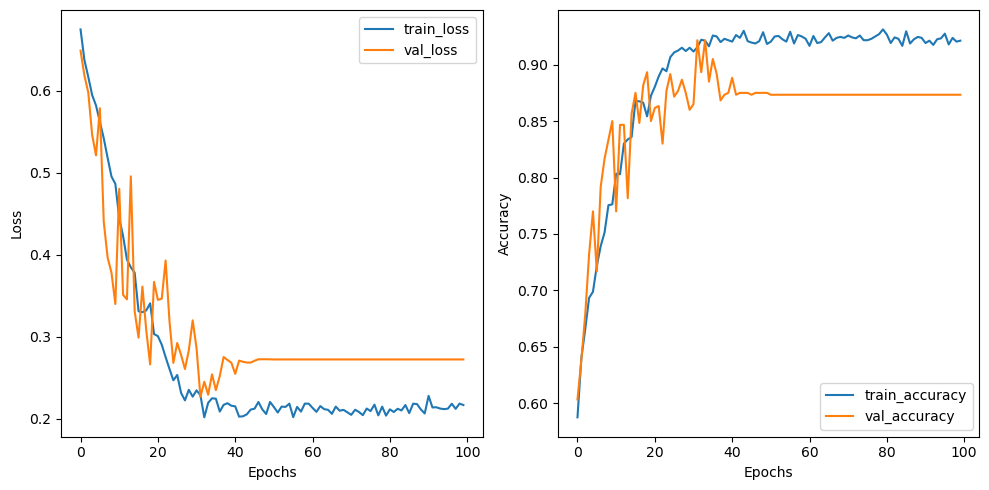

19/19 [==============================] - 2s 83ms/step
              precision    recall  f1-score   support

           0       0.94      0.80      0.87       310
           1       0.82      0.95      0.88       290

    accuracy                           0.87       600
   macro avg       0.88      0.88      0.87       600
weighted avg       0.88      0.87      0.87       600

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_84 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 activation_140 (Activation)  (None, 126, 126, 32)     0         
                                                                 
 max_pooling2d_84 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 c

In [108]:
plot_training_results(results100_ver5, model5)

In [105]:
test_loss, test_acc = model5.evaluate(X_val, y_val)
model_acc_loss(test_acc, test_loss)

19/19 [==============================] - 1s 77ms/step - loss: 0.2723 - accuracy: 0.8733
Model Accuracy (Test data)
________________________________________

Model Accuracy:       0.8733333349227905
Test Loss:           0.2722611427307129
________________________________________



___

##### <div style="text-align: left"><font color = 'purple' size='5'><b>Ver 6 - LAYER REDUCTION</b></font> <b>back to the basics</i></b></div>

<i>Instantiate</i>

<i>Compile</i>

In [96]:
def create_model6():

    #Instantiate model
    model = Sequential()

    # Define and compile your model
    model.add(Conv2D(16, (3, 3), input_shape=(IMG_SIZE, IMG_SIZE, 3), kernel_initializer='he_uniform'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.1))
    
    model.add(Conv2D(32, (3, 3), kernel_initializer='he_uniform'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Dropout(0.1))
    
    model.add(Flatten())
    model.add(Dense(8, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    #lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)
    
    return model

<div style="text-align: center"> <b> 100 Epoch (LR_Scheduler)</b> <i>at <font color = 'red'>64</font> batch</i> with <i><font color = 'blue'> Augmentation </font></i> and <font color='green'><i>Regularization</i></font> </div> 

In [97]:
# Exexcute the model
model8 = create_model6()
results100_ver6_3 = model8.fit(X_train, y_train, batch_size = 32, verbose=1, epochs=100,
                       validation_data= (X_val, y_val))
# Save model
model8.save('model/brain_tumor_base_100_epochs_64_ver6_4.h5')

Epoch 1/100
75/75 [==============================] - 16s 211ms/step - loss: 0.5356 - accuracy: 0.7146 - val_loss: 0.4262 - val_accuracy: 0.8183
Epoch 2/100
75/75 [==============================] - 16s 214ms/step - loss: 0.3976 - accuracy: 0.8062 - val_loss: 0.3625 - val_accuracy: 0.8817
Epoch 3/100
75/75 [==============================] - 16s 214ms/step - loss: 0.3108 - accuracy: 0.8592 - val_loss: 0.2321 - val_accuracy: 0.9000
Epoch 4/100
75/75 [==============================] - 16s 215ms/step - loss: 0.2490 - accuracy: 0.8825 - val_loss: 0.1815 - val_accuracy: 0.9267
Epoch 5/100
75/75 [==============================] - 16s 216ms/step - loss: 0.2073 - accuracy: 0.8975 - val_loss: 0.1483 - val_accuracy: 0.9467
Epoch 6/100
75/75 [==============================] - 16s 214ms/step - loss: 0.2053 - accuracy: 0.9042 - val_loss: 0.1530 - val_accuracy: 0.9500
Epoch 7/100
75/75 [==============================] - 16s 218ms/step - loss: 0.1833 - accuracy: 0.9117 - val_loss: 0.1516 - val_accuracy:

75/75 [==============================] - 17s 221ms/step - loss: 0.0638 - accuracy: 0.9638 - val_loss: 0.1142 - val_accuracy: 0.9667
Epoch 58/100
75/75 [==============================] - 17s 223ms/step - loss: 0.0661 - accuracy: 0.9654 - val_loss: 0.1513 - val_accuracy: 0.9650
Epoch 59/100
75/75 [==============================] - 16s 215ms/step - loss: 0.0635 - accuracy: 0.9642 - val_loss: 0.1147 - val_accuracy: 0.9667
Epoch 60/100
75/75 [==============================] - 16s 215ms/step - loss: 0.0553 - accuracy: 0.9667 - val_loss: 0.1472 - val_accuracy: 0.9667
Epoch 61/100
75/75 [==============================] - 17s 222ms/step - loss: 0.0656 - accuracy: 0.9608 - val_loss: 0.1463 - val_accuracy: 0.9683
Epoch 62/100
75/75 [==============================] - 16s 219ms/step - loss: 0.0581 - accuracy: 0.9629 - val_loss: 0.1331 - val_accuracy: 0.9633
Epoch 63/100
75/75 [==============================] - 16s 215ms/step - loss: 0.0548 - accuracy: 0.9658 - val_loss: 0.1647 - val_accuracy: 0.968

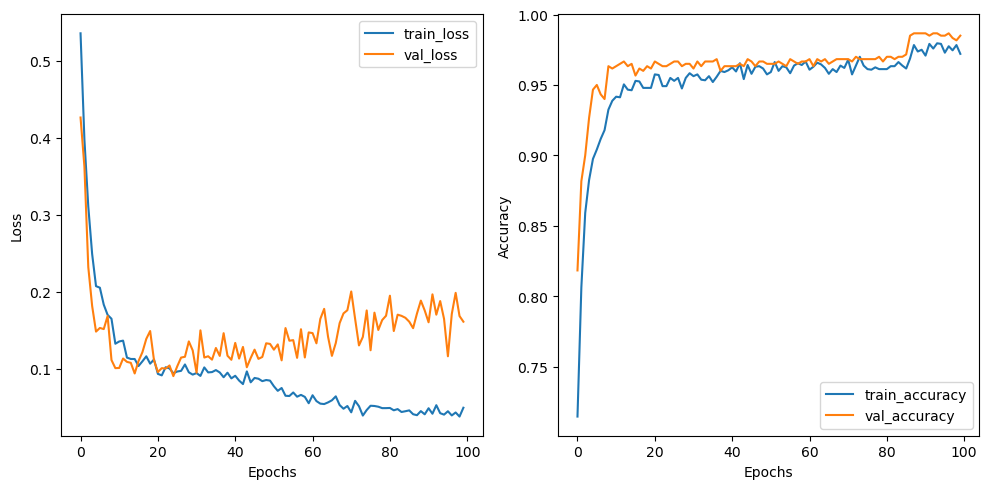

19/19 [==============================] - 1s 48ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       285
           1       0.99      0.98      0.99       315

    accuracy                           0.98       600
   macro avg       0.98      0.99      0.98       600
weighted avg       0.99      0.98      0.99       600

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_78 (Conv2D)          (None, 126, 126, 16)      448       
                                                                 
 activation_119 (Activation)  (None, 126, 126, 16)     0         
                                                                 
 max_pooling2d_78 (MaxPoolin  (None, 63, 63, 16)       0         
 g2D)                                                            
                                                                 
 d

In [98]:
plot_training_results(results100_ver6_3, model8)

In [74]:
# Exexcute the model
model7 = create_model6()
results100_ver6_3 = model6.fit(X_train, y_train, batch_size = 64, verbose=1, epochs=100,
                       validation_data= (X_val, y_val))
# Save model
model6.save('model/brain_tumor_base_100_epochs_64_ver6_2.h5')

Epoch 1/100
38/38 [==============================] - 45s 1s/step - loss: 0.9156 - accuracy: 0.5196 - val_loss: 0.6929 - val_accuracy: 0.5300
Epoch 2/100
38/38 [==============================] - 32s 836ms/step - loss: 0.6931 - accuracy: 0.4963 - val_loss: 0.6928 - val_accuracy: 0.5333
Epoch 3/100
38/38 [==============================] - 32s 853ms/step - loss: 0.6919 - accuracy: 0.5125 - val_loss: 0.6634 - val_accuracy: 0.6450
Epoch 4/100
38/38 [==============================] - 33s 859ms/step - loss: 0.5986 - accuracy: 0.7083 - val_loss: 0.5880 - val_accuracy: 0.7233
Epoch 5/100
38/38 [==============================] - 32s 847ms/step - loss: 0.5564 - accuracy: 0.7429 - val_loss: 0.5500 - val_accuracy: 0.7733
Epoch 6/100
38/38 [==============================] - 33s 857ms/step - loss: 0.5209 - accuracy: 0.7688 - val_loss: 0.5129 - val_accuracy: 0.8033
Epoch 7/100
38/38 [==============================] - 32s 851ms/step - loss: 0.4866 - accuracy: 0.7962 - val_loss: 0.4754 - val_accuracy: 0.

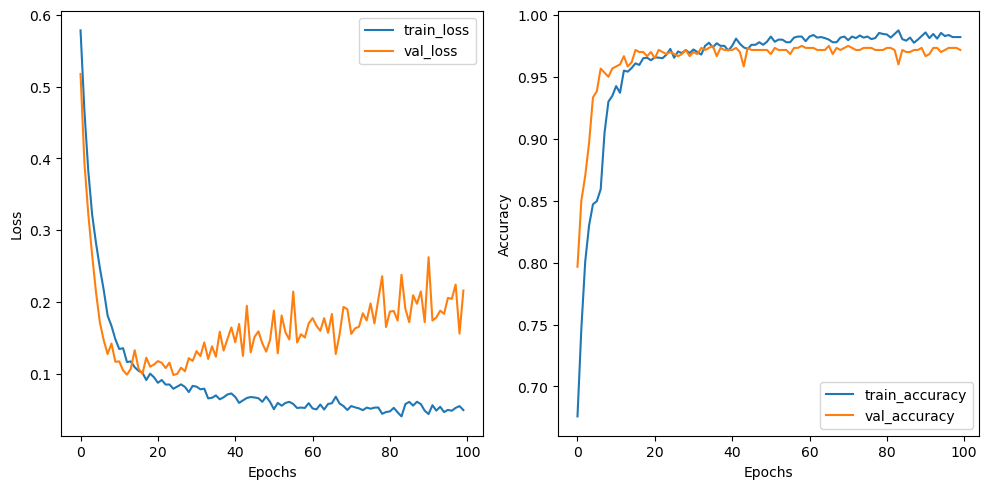

19/19 [==============================] - 1s 48ms/step
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       285
           1       0.97      0.98      0.97       315

    accuracy                           0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_70 (Conv2D)          (None, 126, 126, 16)      448       
                                                                 
 activation_107 (Activation)  (None, 126, 126, 16)     0         
                                                                 
 max_pooling2d_70 (MaxPoolin  (None, 63, 63, 16)       0         
 g2D)                                                            
                                                                 
 d

In [89]:
plot_training_results(results100_ver6_3, model8)

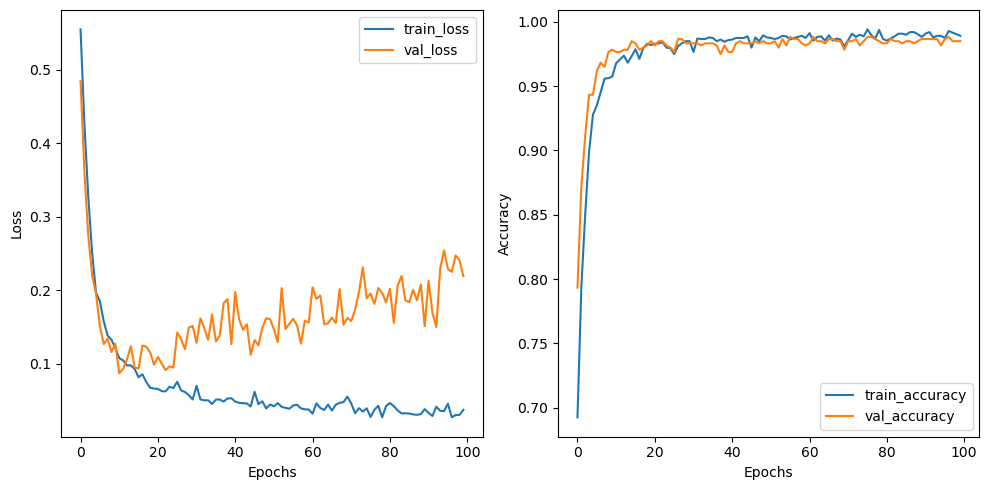

19/19 [==============================] - 1s 44ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       285
           1       0.99      0.98      0.99       315

    accuracy                           0.98       600
   macro avg       0.98      0.99      0.98       600
weighted avg       0.99      0.98      0.99       600

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_68 (Conv2D)          (None, 126, 126, 16)      448       
                                                                 
 activation_104 (Activation)  (None, 126, 126, 16)     0         
                                                                 
 max_pooling2d_68 (MaxPoolin  (None, 63, 63, 16)       0         
 g2D)                                                            
                                                                 
 d

In [86]:
plot_training_results(results100_ver6_3, model7)

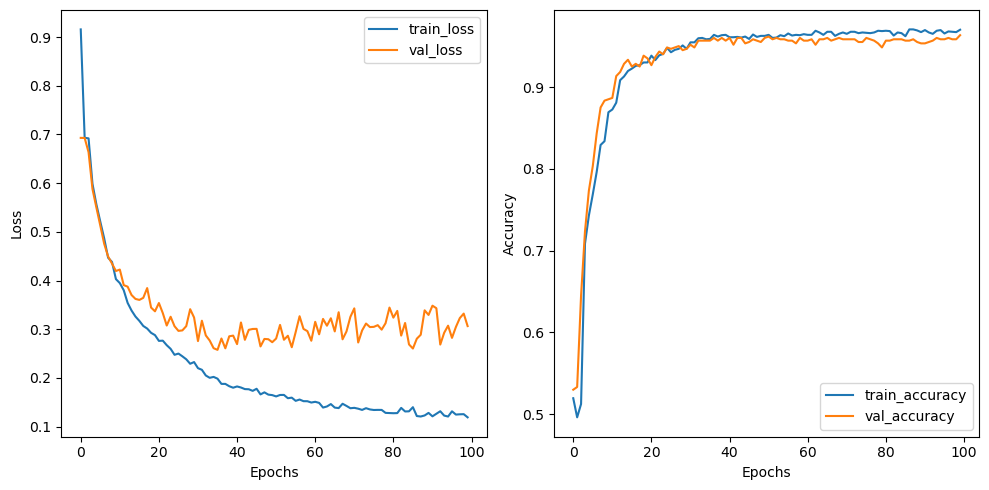

19/19 [==============================] - 2s 88ms/step
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       285
           1       0.95      0.98      0.97       315

    accuracy                           0.96       600
   macro avg       0.96      0.96      0.96       600
weighted avg       0.96      0.96      0.96       600

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_58 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 activation_89 (Activation)  (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d_58 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 d

In [75]:
plot_training_results(results100_ver6_3, model6)

In [ ]:
plot_training_results(results100_ver6, model6)

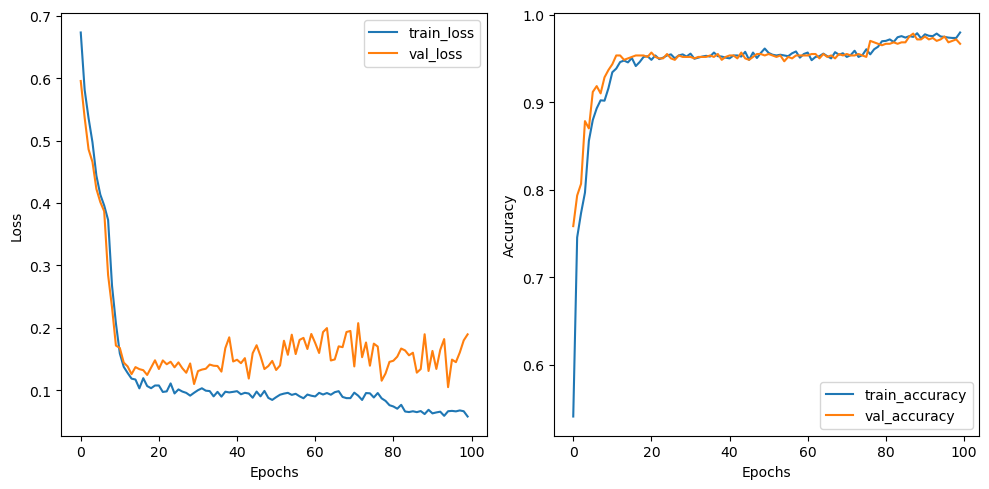

19/19 [==============================] - 2s 83ms/step
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       310
           1       0.97      0.96      0.97       290

    accuracy                           0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_89 (Conv2D)          (None, 126, 126, 64)      1792      
                                                                 
 activation_149 (Activation)  (None, 126, 126, 64)     0         
                                                                 
 max_pooling2d_89 (MaxPoolin  (None, 63, 63, 64)       0         
 g2D)                                                            
                                                                 
 f

In [118]:
plot_training_results(results100_ver6, model6)

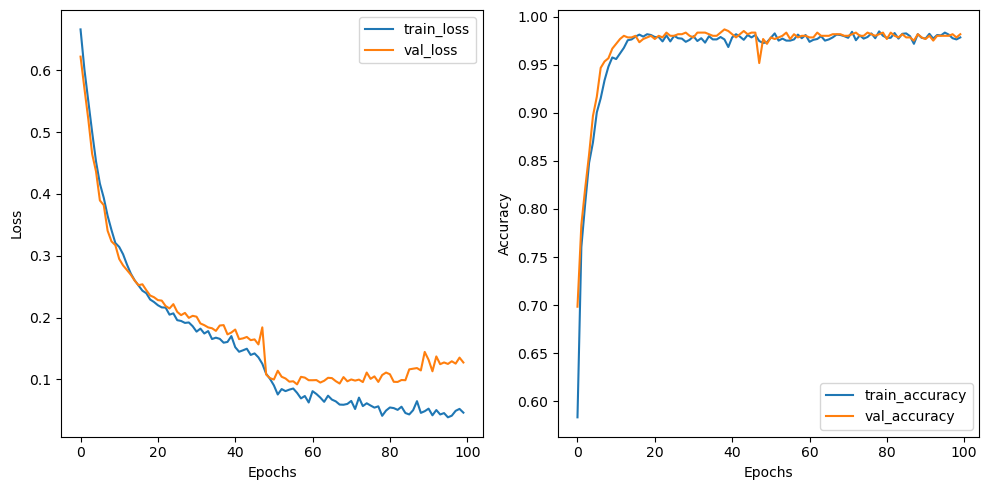

19/19 [==============================] - 1s 53ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       286
           1       0.98      0.98      0.98       314

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 activation_55 (Activation)  (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 f

In [92]:
plot_training_results(results100)

In [93]:
test_loss, test_acc = model.evaluate(X_val, y_val)
model_acc_loss(test_acc, test_loss)

19/19 [==============================] - 1s 45ms/step - loss: 0.1273 - accuracy: 0.9817
Model Accuracy (Test data)
________________________________________

Model Accuracy:       0.9816666841506958
Test Loss:           0.12730015814304352
________________________________________



<div style="text-align: justify">

From the previous attempts to tune the model (adding more layers, augmentation, regularization) it all makes sense to do with a complex model, but since this model is simple, it wouldnt make sense to start at a high point, but start with less features to have a better understanding of why the loss is occuring. 

Having too much hyperparameters can make a simple model look complex. As we can see, with the reduction of layers and parameters, the model able to get closer to a more uniformed model that can properly train the model.

Although its still not perfect, adding the necessary parameters to the model can fix the divergence happening in this version.
    </div>

___

##### <div style="text-align: left"><font color = 'purple' size='5'><b>Ver 7 - SIMPLE MODEL </b></font></div>

<i>Instantiate</i>

In [167]:
#Instantiate model
model = Sequential()

<i>Compile</i>

In [168]:
# # Define and compile your model
# model.add(Conv2D(32, (3, 3), input_shape=(IMG_SIZE, IMG_SIZE, 3)))
# #model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Flatten())
# model.add(Dense(16, activation = 'relu'))
# model.add(Dropout(0.2))
# model.add(Dense(1))
# model.add(Activation('sigmoid'))

# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


model = Sequential()
model.add(Conv2D(16, (3, 3), input_shape=(IMG_SIZE, IMG_SIZE, 3), activation='relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Define the learning rate scheduler callback
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)



<div style="text-align: center"> <b> 100 Epoch </b><i>(No Dropout)</i></div> 

In [169]:
# Exexcute the model
results100 = model.fit(X_train, y_train, batch_size = 64, verbose=1, epochs=100,
                       validation_data= (X_val, y_val), callbacks=[lr_scheduler])

# Save model
model.save('model/brain_tumor_base_100_epochs_64_basics_v2.h5')

Epoch 1/100
38/38 [==============================] - 20s 515ms/step - loss: 0.5194 - accuracy: 0.7292 - val_loss: 0.3660 - val_accuracy: 0.8267 - lr: 0.0010
Epoch 2/100
38/38 [==============================] - 20s 525ms/step - loss: 0.2372 - accuracy: 0.9179 - val_loss: 0.2043 - val_accuracy: 0.9417 - lr: 0.0010
Epoch 3/100
38/38 [==============================] - 20s 526ms/step - loss: 0.1045 - accuracy: 0.9775 - val_loss: 0.1472 - val_accuracy: 0.9633 - lr: 0.0010
Epoch 4/100
38/38 [==============================] - 20s 530ms/step - loss: 0.0551 - accuracy: 0.9892 - val_loss: 0.1065 - val_accuracy: 0.9717 - lr: 0.0010
Epoch 5/100
38/38 [==============================] - 20s 524ms/step - loss: 0.0302 - accuracy: 0.9946 - val_loss: 0.0830 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 6/100
38/38 [==============================] - 20s 529ms/step - loss: 0.0218 - accuracy: 0.9992 - val_loss: 0.1012 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 7/100
38/38 [==============================] - 20s 5

38/38 [==============================] - 20s 538ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0887 - val_accuracy: 0.9783 - lr: 1.0000e-09
Epoch 46/100
38/38 [==============================] - 20s 532ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0887 - val_accuracy: 0.9783 - lr: 1.0000e-10
Epoch 47/100
38/38 [==============================] - 20s 529ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0887 - val_accuracy: 0.9783 - lr: 1.0000e-10
Epoch 48/100
38/38 [==============================] - 20s 526ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0887 - val_accuracy: 0.9783 - lr: 1.0000e-10
Epoch 49/100
38/38 [==============================] - 20s 530ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0887 - val_accuracy: 0.9783 - lr: 1.0000e-10
Epoch 50/100
38/38 [==============================] - ETA: 0s - loss: 0.0010 - accuracy: 1.0000
Epoch 50: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-11.
38/38 [=======================

Epoch 88/100
38/38 [==============================] - 20s 531ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0887 - val_accuracy: 0.9783 - lr: 1.0000e-18
Epoch 89/100
38/38 [==============================] - 20s 523ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0887 - val_accuracy: 0.9783 - lr: 1.0000e-18
Epoch 90/100
38/38 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000
Epoch 90: ReduceLROnPlateau reducing learning rate to 1.000000045813705e-19.
38/38 [==============================] - 20s 526ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0887 - val_accuracy: 0.9783 - lr: 1.0000e-18
Epoch 91/100
38/38 [==============================] - 20s 521ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0887 - val_accuracy: 0.9783 - lr: 1.0000e-19
Epoch 92/100
38/38 [==============================] - 20s 528ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0887 - val_accuracy: 0.9783 - lr: 1.0000e-19
Epoch 93/100
38/38 [==========

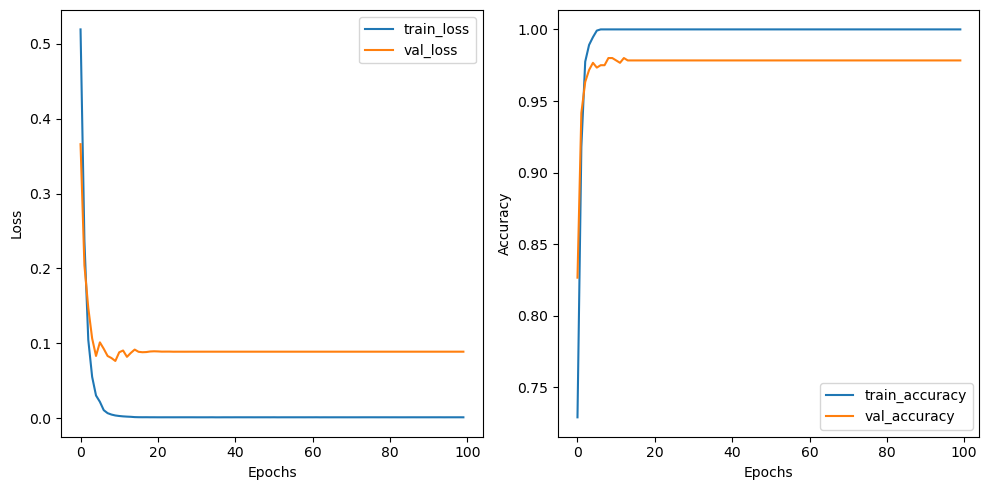

19/19 [==============================] - 1s 30ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       286
           1       0.99      0.97      0.98       314

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600

Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_59 (Conv2D)          (None, 126, 126, 16)      448       
                                                                 
 dropout_45 (Dropout)        (None, 126, 126, 16)      0         
                                                                 
 flatten_32 (Flatten)        (None, 254016)            0         
                                                                 
 dropout_46 (Dropout)        (None, 254016)            0         
  

In [170]:
plot_training_results(results100)

In [162]:
test_loss, test_acc = model.evaluate(X_val, y_val)
model_acc_loss(test_acc, test_loss)

19/19 [==============================] - 1s 30ms/step - loss: 0.0899 - accuracy: 0.9767
Model Accuracy (Test data)
________________________________________

Model Accuracy:       0.9766666889190674
Test Loss:           0.0898614227771759
________________________________________



As clear as it seems, its overfitting. This can be due to several possibilities, but one area need to explore is the image size. Due to the fact that the dataset is fairly small, no need to capture so much details about the image, unlike a fairly large dataset where having more details and patterns is essential for better performance.


### OTHERS (Code below)

Epoch 1/30
75/75 [==============================] - 58s 764ms/step - loss: 0.7860 - accuracy: 0.5550 - val_loss: 0.7290 - val_accuracy: 0.5033
Epoch 2/30
75/75 [==============================] - 57s 752ms/step - loss: 0.7187 - accuracy: 0.5067 - val_loss: 0.7103 - val_accuracy: 0.5083
Epoch 3/30
75/75 [==============================] - 61s 816ms/step - loss: 0.7064 - accuracy: 0.5142 - val_loss: 0.6996 - val_accuracy: 0.6133
Epoch 4/30
75/75 [==============================] - 58s 775ms/step - loss: 0.6940 - accuracy: 0.5517 - val_loss: 0.6878 - val_accuracy: 0.5467
Epoch 5/30
75/75 [==============================] - 58s 779ms/step - loss: 0.6647 - accuracy: 0.6313 - val_loss: 0.6893 - val_accuracy: 0.5400
Epoch 6/30
75/75 [==============================] - 58s 765ms/step - loss: 0.6659 - accuracy: 0.6142 - val_loss: 0.6644 - val_accuracy: 0.5883
Epoch 7/30
75/75 [==============================] - 58s 770ms/step - loss: 0.6527 - accuracy: 0.6450 - val_loss: 0.6298 - val_accuracy: 0.6550

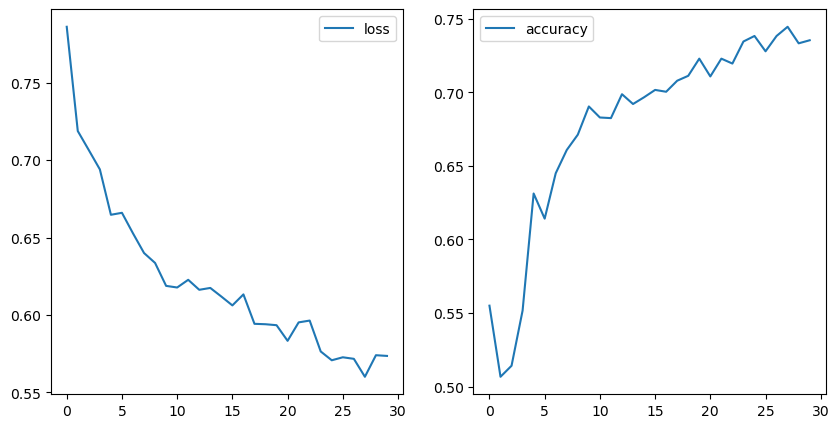

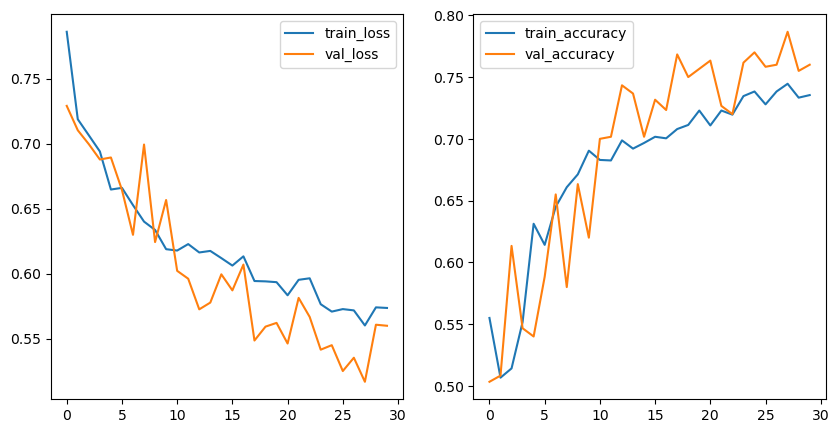

In [100]:
from tensorflow.keras.regularizers import l2

model = Sequential()

model.add(Conv2D(64, (3,3), input_shape=(IMG_SIZE, IMG_SIZE, 3), kernel_regularizer=l2(0.001)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3), kernel_regularizer=l2(0.001)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3,3), kernel_regularizer=l2(0.001)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(64, kernel_regularizer=l2(0.001)))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(1))
model.add(Activation('sigmoid'))



# LEARNING RATE SCHEDULE (ExponentialDecay)
# MODIFICATIONS CAN BE MADE IN THE TUNING PARAMETERS SECTION ABOVE
learning_rate = ExponentialDecay(initial_learning_rate=initial_lr, decay_steps=decay_steps, decay_rate=decay_rate)
optimizer = Adam(learning_rate=learning_rate)


# AUGMENTATION (ImageDataGenerator)
# MODIFICATIONS CAN BE MADE IN THE TUNING PARAMETERS SECTION ABOVE
datagen = ImageDataGenerator(
    rotation_range=rotation_range,
    width_shift_range=width_shift_range,
    height_shift_range=height_shift_range,
    shear_range=shear_range,
    zoom_range=zoom_range,
    horizontal_flip=horizontal_flip,
    fill_mode=fill_mode
)

# Compile
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Run model (Augmented version)
results_augmented = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                              validation_data=(X_val, y_val),
                              verbose=1,
                              shuffle=False,
                              epochs=epoch)

# Save model (Augmented version)
model.save('brain_tumor_30_epochs_augmented_v13.h5')


sigmoid_loss = results_augmented.history['loss']
sigmoid_accuracy = results_augmented.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results_augmented.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results_augmented.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy');

train_loss = results_augmented.history['loss']
train_acc = results_augmented.history['accuracy']
val_loss = results_augmented.history['val_loss']
val_acc = results_augmented.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results_augmented.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results_augmented.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results_augmented.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results_augmented.epoch, y=val_acc, ax=ax2, label='val_accuracy');

___

Epoch 1/30
75/75 [==============================] - 58s 760ms/step - loss: 0.6678 - accuracy: 0.5913 - val_loss: 0.6519 - val_accuracy: 0.5800
Epoch 2/30
75/75 [==============================] - 57s 755ms/step - loss: 0.6347 - accuracy: 0.6421 - val_loss: 0.5663 - val_accuracy: 0.7233
Epoch 3/30
75/75 [==============================] - 56s 752ms/step - loss: 0.5913 - accuracy: 0.7021 - val_loss: 0.5850 - val_accuracy: 0.6917
Epoch 4/30
75/75 [==============================] - 56s 751ms/step - loss: 0.6002 - accuracy: 0.6783 - val_loss: 0.5138 - val_accuracy: 0.7717
Epoch 5/30
75/75 [==============================] - 56s 742ms/step - loss: 0.5548 - accuracy: 0.7225 - val_loss: 0.5845 - val_accuracy: 0.7117
Epoch 6/30
75/75 [==============================] - 60s 800ms/step - loss: 0.5507 - accuracy: 0.7183 - val_loss: 0.5181 - val_accuracy: 0.7400
Epoch 7/30
75/75 [==============================] - 59s 787ms/step - loss: 0.5588 - accuracy: 0.7237 - val_loss: 0.4900 - val_accuracy: 0.7783

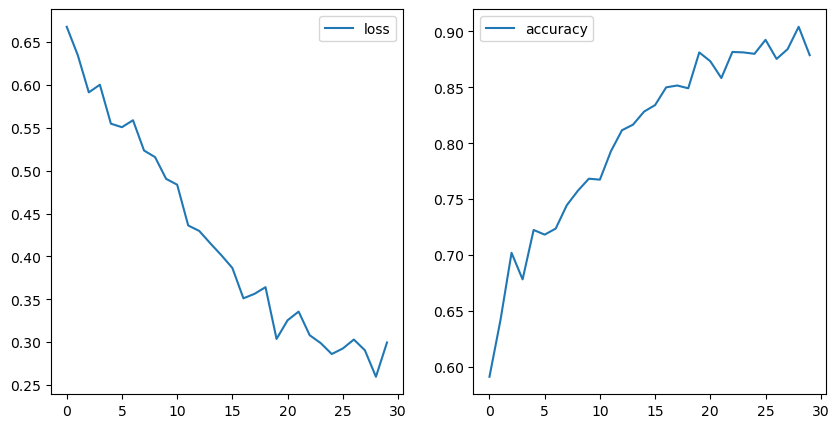

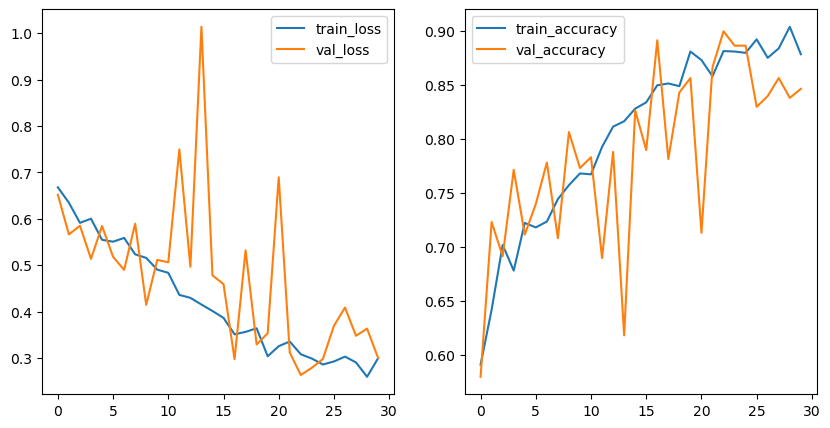

In [95]:






model = Sequential()

model.add(Conv2D(64, (3,3), input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# model.add(Conv2D(128, (3,3), kernel_initializer='he_uniform'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))



# LEARNING RATE SCHEDULE (ExponentialDecay)
# MODIFICATIONS CAN BE MADE IN THE TUNING PARAMETERS SECTION ABOVE
learning_rate = ExponentialDecay(initial_learning_rate=initial_lr, decay_steps=decay_steps, decay_rate=decay_rate)
optimizer = Adam(learning_rate=learning_rate)


# AUGMENTATION (ImageDataGenerator)
# MODIFICATIONS CAN BE MADE IN THE TUNING PARAMETERS SECTION ABOVE
datagen = ImageDataGenerator(
    rotation_range=rotation_range,
    width_shift_range=width_shift_range,
    height_shift_range=height_shift_range,
    shear_range=shear_range,
    zoom_range=zoom_range,
    horizontal_flip=horizontal_flip,
    fill_mode=fill_mode
)

# Compile
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Run model (Augmented version)
results_augmented = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                              validation_data=(X_val, y_val),
                              verbose=1,
                              shuffle=False,
                              epochs=epoch)

# Save model (Augmented version)
model.save('brain_tumor_30_epochs_augmented_v13.h5')


sigmoid_loss = results_augmented.history['loss']
sigmoid_accuracy = results_augmented.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results_augmented.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results_augmented.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy');

train_loss = results_augmented.history['loss']
train_acc = results_augmented.history['accuracy']
val_loss = results_augmented.history['val_loss']
val_acc = results_augmented.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results_augmented.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results_augmented.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results_augmented.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results_augmented.epoch, y=val_acc, ax=ax2, label='val_accuracy');

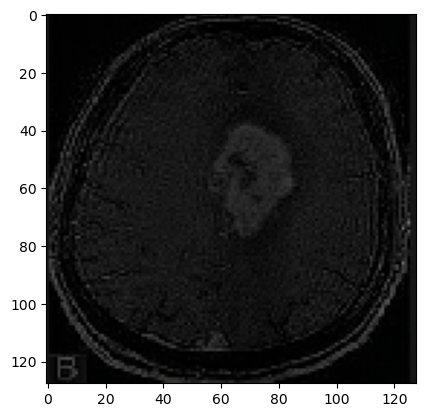

In [92]:
plt.imshow(X_train[197])

<b><font color='red'> EXECUTE </font></b>

In [56]:
results = model.fit(X_train, y_train, batch_size = 16, 
          verbose=1, 
          epochs=100,
          validation_data= (X_train, y_train),
          shuffle = False)

model.save('brain_tumor_100epochs_v4.5')

Epoch 1/100
150/150 [==============================] - 7s 45ms/step - loss: 0.5556 - accuracy: 0.7242 - val_loss: 0.4895 - val_accuracy: 0.7821
Epoch 2/100
150/150 [==============================] - 7s 45ms/step - loss: 0.4215 - accuracy: 0.8200 - val_loss: 0.3150 - val_accuracy: 0.8687
Epoch 3/100
150/150 [==============================] - 7s 45ms/step - loss: 0.2984 - accuracy: 0.8783 - val_loss: 0.1997 - val_accuracy: 0.9333
Epoch 4/100
150/150 [==============================] - 7s 46ms/step - loss: 0.2233 - accuracy: 0.9150 - val_loss: 0.1320 - val_accuracy: 0.9521
Epoch 5/100
150/150 [==============================] - 7s 48ms/step - loss: 0.1573 - accuracy: 0.9421 - val_loss: 0.0754 - val_accuracy: 0.9746
Epoch 6/100
150/150 [==============================] - 7s 48ms/step - loss: 0.1138 - accuracy: 0.9575 - val_loss: 0.0505 - val_accuracy: 0.9862
Epoch 7/100
150/150 [==============================] - 7s 48ms/step - loss: 0.0867 - accuracy: 0.9712 - val_loss: 0.0292 - val_accuracy:

INFO:tensorflow:Assets written to: brain_tumor_100epochs_v4.5\assets


INFO:tensorflow:Assets written to: brain_tumor_100epochs_v4.5\assets


___

### <b>Data Augmentation</b> <i>(Using ImageDataGenerator)</i>

In [24]:
#Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

#Compile
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

<b><font color='red'> EXECUTE </font></b> <i>(with Augmentation)</i>

In [25]:
#Run model (Augmented version)
results_augmented = model.fit(datagen.flow(X_train, y_train, batch_size=32), 
                              validation_data= (X_train, y_train), 
                              verbose=1, 
                              shuffle = False, 
                              epochs=500)

#Save model (Augmented version)
model.save('brain_tumor_500_epochs_augmented_v3.h5')

Epoch 1/500
75/75 [==============================] - 8s 97ms/step - loss: 0.6753 - accuracy: 0.5758 - val_loss: 0.6871 - val_accuracy: 0.5471
Epoch 2/500
75/75 [==============================] - 7s 99ms/step - loss: 0.6478 - accuracy: 0.6196 - val_loss: 0.6679 - val_accuracy: 0.5933
Epoch 3/500
75/75 [==============================] - 9s 119ms/step - loss: 0.6269 - accuracy: 0.6617 - val_loss: 0.6397 - val_accuracy: 0.6358
Epoch 4/500
75/75 [==============================] - 13s 168ms/step - loss: 0.6061 - accuracy: 0.6825 - val_loss: 0.5642 - val_accuracy: 0.7113
Epoch 5/500
75/75 [==============================] - 9s 123ms/step - loss: 0.6020 - accuracy: 0.6808 - val_loss: 0.5123 - val_accuracy: 0.7621
Epoch 6/500
75/75 [==============================] - 11s 142ms/step - loss: 0.5971 - accuracy: 0.6946 - val_loss: 0.5247 - val_accuracy: 0.7513
Epoch 7/500
75/75 [==============================] - 10s 129ms/step - loss: 0.5819 - accuracy: 0.6996 - val_loss: 0.5094 - val_accuracy: 0.770

Epoch 58/500
75/75 [==============================] - 8s 103ms/step - loss: 0.2060 - accuracy: 0.9212 - val_loss: 0.1163 - val_accuracy: 0.9592
Epoch 59/500
75/75 [==============================] - 8s 105ms/step - loss: 0.1960 - accuracy: 0.9267 - val_loss: 0.1196 - val_accuracy: 0.9471
Epoch 60/500
75/75 [==============================] - 8s 103ms/step - loss: 0.1820 - accuracy: 0.9358 - val_loss: 0.1351 - val_accuracy: 0.9433
Epoch 61/500
75/75 [==============================] - 8s 102ms/step - loss: 0.1873 - accuracy: 0.9304 - val_loss: 0.1270 - val_accuracy: 0.9529
Epoch 62/500
75/75 [==============================] - 8s 104ms/step - loss: 0.1899 - accuracy: 0.9317 - val_loss: 0.1251 - val_accuracy: 0.9500
Epoch 63/500
75/75 [==============================] - 8s 104ms/step - loss: 0.1675 - accuracy: 0.9404 - val_loss: 0.1562 - val_accuracy: 0.9408
Epoch 64/500
75/75 [==============================] - 8s 106ms/step - loss: 0.1798 - accuracy: 0.9329 - val_loss: 0.0952 - val_accuracy:

Epoch 115/500
75/75 [==============================] - 8s 108ms/step - loss: 0.1209 - accuracy: 0.9550 - val_loss: 0.0833 - val_accuracy: 0.9717
Epoch 116/500
75/75 [==============================] - 8s 107ms/step - loss: 0.1220 - accuracy: 0.9546 - val_loss: 0.0715 - val_accuracy: 0.9733
Epoch 117/500
75/75 [==============================] - 8s 108ms/step - loss: 0.1249 - accuracy: 0.9529 - val_loss: 0.0609 - val_accuracy: 0.9771
Epoch 118/500
75/75 [==============================] - 8s 106ms/step - loss: 0.1015 - accuracy: 0.9629 - val_loss: 0.0774 - val_accuracy: 0.9712
Epoch 119/500
75/75 [==============================] - 8s 105ms/step - loss: 0.1104 - accuracy: 0.9604 - val_loss: 0.0591 - val_accuracy: 0.9783
Epoch 120/500
75/75 [==============================] - 8s 105ms/step - loss: 0.1011 - accuracy: 0.9625 - val_loss: 0.1192 - val_accuracy: 0.9608
Epoch 121/500
75/75 [==============================] - 8s 106ms/step - loss: 0.1129 - accuracy: 0.9588 - val_loss: 0.0484 - val_ac

75/75 [==============================] - 8s 106ms/step - loss: 0.0685 - accuracy: 0.9767 - val_loss: 0.0527 - val_accuracy: 0.9800
Epoch 228/500
75/75 [==============================] - 8s 105ms/step - loss: 0.0784 - accuracy: 0.9733 - val_loss: 0.0205 - val_accuracy: 0.9942
Epoch 229/500
75/75 [==============================] - 8s 105ms/step - loss: 0.0653 - accuracy: 0.9771 - val_loss: 0.0523 - val_accuracy: 0.9829
Epoch 230/500
75/75 [==============================] - 8s 107ms/step - loss: 0.0673 - accuracy: 0.9737 - val_loss: 0.0317 - val_accuracy: 0.9892
Epoch 231/500
75/75 [==============================] - 8s 106ms/step - loss: 0.0721 - accuracy: 0.9754 - val_loss: 0.0243 - val_accuracy: 0.9933
Epoch 232/500
75/75 [==============================] - 8s 106ms/step - loss: 0.0630 - accuracy: 0.9787 - val_loss: 0.0369 - val_accuracy: 0.9846
Epoch 233/500
75/75 [==============================] - 8s 106ms/step - loss: 0.0606 - accuracy: 0.9792 - val_loss: 0.0204 - val_accuracy: 0.9925

75/75 [==============================] - 8s 103ms/step - loss: 0.0465 - accuracy: 0.9850 - val_loss: 0.0153 - val_accuracy: 0.9962
Epoch 340/500
75/75 [==============================] - 8s 103ms/step - loss: 0.0469 - accuracy: 0.9837 - val_loss: 0.0319 - val_accuracy: 0.9904
Epoch 341/500
75/75 [==============================] - 8s 103ms/step - loss: 0.0324 - accuracy: 0.9887 - val_loss: 0.0082 - val_accuracy: 0.9962
Epoch 342/500
75/75 [==============================] - 8s 104ms/step - loss: 0.0552 - accuracy: 0.9850 - val_loss: 0.0854 - val_accuracy: 0.9696
Epoch 343/500
75/75 [==============================] - 8s 103ms/step - loss: 0.0564 - accuracy: 0.9821 - val_loss: 0.0394 - val_accuracy: 0.9862
Epoch 344/500
75/75 [==============================] - 8s 103ms/step - loss: 0.0537 - accuracy: 0.9808 - val_loss: 0.0725 - val_accuracy: 0.9804
Epoch 345/500
75/75 [==============================] - 8s 104ms/step - loss: 0.0452 - accuracy: 0.9833 - val_loss: 0.0183 - val_accuracy: 0.9942

75/75 [==============================] - 8s 109ms/step - loss: 0.0217 - accuracy: 0.9929 - val_loss: 0.0454 - val_accuracy: 0.9862
Epoch 452/500
75/75 [==============================] - 8s 106ms/step - loss: 0.0416 - accuracy: 0.9875 - val_loss: 0.0743 - val_accuracy: 0.9787
Epoch 453/500
75/75 [==============================] - 8s 106ms/step - loss: 0.0370 - accuracy: 0.9892 - val_loss: 0.0146 - val_accuracy: 0.9942
Epoch 454/500
75/75 [==============================] - 8s 107ms/step - loss: 0.0527 - accuracy: 0.9817 - val_loss: 0.1084 - val_accuracy: 0.9717
Epoch 455/500
75/75 [==============================] - 8s 108ms/step - loss: 0.0283 - accuracy: 0.9912 - val_loss: 0.0226 - val_accuracy: 0.9925
Epoch 456/500
75/75 [==============================] - 8s 108ms/step - loss: 0.0268 - accuracy: 0.9925 - val_loss: 0.0094 - val_accuracy: 0.9975
Epoch 457/500
75/75 [==============================] - 8s 109ms/step - loss: 0.0487 - accuracy: 0.9842 - val_loss: 0.0171 - val_accuracy: 0.9929

___

<b> Evaluate model against the test data</b>

In [57]:
test_loss, test_acc = model.evaluate(X_test, y_test)

19/19 [==============================] - 0s 16ms/step - loss: 0.2514 - accuracy: 0.9783


In [58]:
model_acc_loss(test_acc, test_loss)

Model Accuracy (Test data)
________________________________________

Model Accuracy:       0.9783333539962769
Test Loss:           0.2514435052871704
________________________________________



___

<i>Summary</i>

In [61]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 activation_20 (Activation)  (None, 62, 62, 32)        0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 29, 29, 32)        9248      
                                                                 
 activation_21 (Activation)  (None, 29, 29, 32)        0         
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                 

In [42]:
results.__dict__

{'validation_data': None,
 'model': <keras.engine.sequential.Sequential at 0x1c9d8a470d0>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [0.5490754842758179,
   0.42540547251701355,
   0.31456440687179565,
   0.22132433950901031,
   0.16236194968223572,
   0.11021943390369415,
   0.0695020854473114,
   0.05887587368488312,
   0.03215130791068077,
   0.025531752035021782],
  'accuracy': [0.7233333587646484,
   0.809166669845581,
   0.8700000047683716,
   0.909583330154419,
   0.9454166889190674,
   0.9641666412353516,
   0.9791666865348816,
   0.9829166531562805,
   0.9920833110809326,
   0.9929166436195374],
  'val_loss': [0.4515177011489868,
   0.31613463163375854,
   0.2116173654794693,
   0.15402743220329285,
   0.09838595241308212,
   0.05772896483540535,
   0.0352964885532856,
   0.025901062414050102,
   0.019818419590592384,
   0.009129732847213745],
  'val_accuracy': [0.7929166555404663,
   0.8704166412353516,
   0.9045833349227905,
   0.94125002

### <b><font size = '5' color = 'green'> MODEL EVALUATION (with AUGMENTATION) </font></b>

<i> Evaluation </i>

In [26]:
test_loss, test_acc = model.evaluate(X_test, y_test)

19/19 [==============================] - 1s 34ms/step - loss: 0.0810 - accuracy: 0.9800


<i> Model Accuracy and Test Loss </i>

In [38]:
model_acc_loss(test_acc, test_loss)

Model Accuracy (Test data)
________________________________________

Model Accuracy:       0.9800000190734863
Test Loss:           0.08096947520971298
________________________________________



<i>Attribute and values</i>

In [28]:
results_augmented.__dict__

{'validation_data': None,
 'model': <keras.engine.sequential.Sequential at 0x16e0e5022e0>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [0.6753212809562683,
   0.6478011012077332,
   0.6269063353538513,
   0.6061310768127441,
   0.6020047664642334,
   0.597112238407135,
   0.5818744897842407,
   0.5740976333618164,
   0.5677558779716492,
   0.5801303386688232,
   0.5524659752845764,
   0.5446001887321472,
   0.5423131585121155,
   0.5261513590812683,
   0.5086605548858643,
   0.4806669056415558,
   0.4605681300163269,
   0.4338361620903015,
   0.423114150762558,
   0.4380134046077728,
   0.438005268573761,
   0.4100959897041321,
   0.3702140748500824,
   0.3764950931072235,
   0.35320189595222473,
   0.3603604733943939,
   0.3238241374492645,
   0.32773640751838684,
   0.31095102429389954,
   0.30320921540260315,
   0.3389776647090912,
   0.32020601630210876,
   0.3086368441581726,
   0.29359883069992065,
   0.2757415175437927,
   0.26882022619247437,


<i><font color = 'blue'>Accuracy and Loss Plot </font></i>

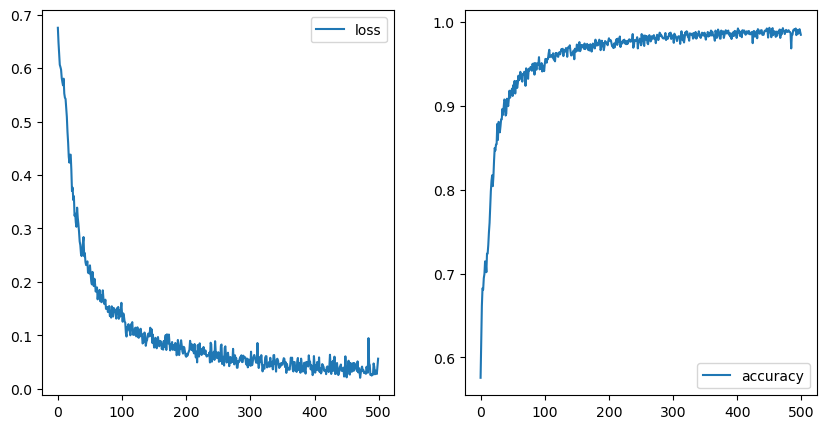

In [59]:
sigmoid_loss = results_augmented.history['loss']
sigmoid_accuracy = results_augmented.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results_augmented.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results_augmented.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy');

### Evaluate Model

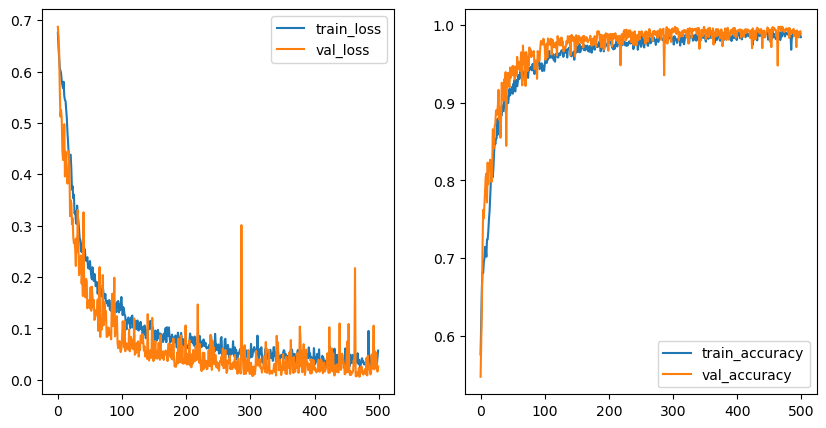

In [60]:
train_loss = results_augmented.history['loss']
train_acc = results_augmented.history['accuracy']
val_loss = results_augmented.history['val_loss']
val_acc = results_augmented.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results_augmented.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results_augmented.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results_augmented.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results_augmented.epoch, y=val_acc, ax=ax2, label='val_accuracy');

In [143]:
pred_tumor_list = list_dir(pred_tumor)
for i in range(len(pred_tumor_list)):
    pred_tumor_list[i] = pred_tumor + img_dir + pred_tumor_list[i]

In [63]:
# testing_predictions = model.predict(X_test)
# #y_pred = model.predict(X_test)
# print(classification_report(y_test,testing_predictions))
# print(testing_predictions)

# #print(y_pred)

y_pred_prob = model.predict(X_test)

# Convert probabilities to class labels
threshold = 0.5
y_pred = (y_pred_prob > threshold).astype(int)
# print(y_pred)


# Print classification report
print(classification_report(y_test, y_pred, zero_division=1))

19/19 [==============================] - 0s 16ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       306
           1       0.98      0.98      0.98       294

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600



<b> Get all the data in the directory data/validation (Train: 500 images) (Test: 100 images), and reshape them </b>

#### <b><font color = 'red'>LOAD THE DATA</font> </b>

In [340]:
df_list = list(yes_no_df['path'].astype(str))

In [317]:
def load_images_from_directory(train_dir):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

#     validation_generator = test_datagen.flow_from_directory(
#         val_dir,
#         target_size=(150, 150),
#         batch_size=32,
#         class_mode='binary')

#     predict_generator = test_datagen.flow_from_directory(
#         pred_dir,
#         target_size=(150, 150),
#         batch_size=32,
#         class_mode=None,
#         shuffle=False)

    return train_generator #, validation_generator, predict_generator

In [348]:
load_images_from_directory('data/')

Found 0 images belonging to 0 classes.


In [ ]:


train_img_dir = 'Br35H-Mask-RCNN/VAL/'
test_img_dir = 'Br35H-Mask-RCNN/TEST/'

In [82]:
train_generator = ImageDataGenerator().flow_from_directory(
    train_img_dir,
    target_size= (256, 256),
    batch_size = 500)

Found 0 images belonging to 0 classes.


In [83]:
test_generator = ImageDataGenerator().flow_from_directory(
    test_img_dir,
    target_size= (256, 256),
    batch_size = 100)

Found 0 images belonging to 0 classes.


In [35]:
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

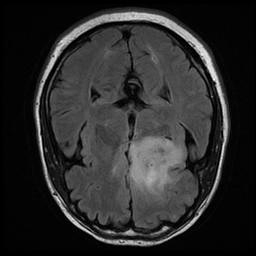

In [36]:
array_to_img(train_images[10])

<b> Transform the matrix </b>

Train

In [38]:
train_img_unrow = train_images.reshape(500, -1).T

In [39]:
np.shape(train_img_unrow)

(196608, 500)

Test

In [40]:
m = 100
test_img_unrow = test_images.reshape(m, -1).T

In [41]:
np.shape(test_img_unrow)

(196608, 100)

Class Indices

In [43]:
train_generator.class_indices

{'no': 0, 'yes': 1}

In [44]:
train_labels_final = train_labels.T[[1]]

In [45]:
np.shape(train_labels_final)

(1, 500)

In [46]:
test_labels_final = test_labels.T[[1]]

In [47]:
np.shape(test_labels_final)

(1, 100)

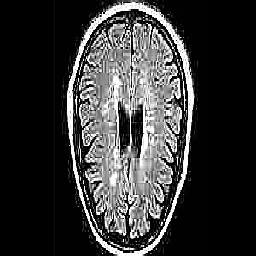

In [48]:
array_to_img(train_images[240])

In [49]:
train_labels_final[:,240]

array([0.], dtype=float32)

### Data Standardization

In [50]:
train_img_final = train_img_unrow/255
test_img_final = test_img_unrow/255

type(test_img_unrow)

numpy.ndarray

### Logistic Regression-based Neural Network

<b> Initialize b </b>

In [51]:
b = 0

<b> Initialize w </b>

In [52]:
def init_w(n):
    w = np.zeros((n,1))
    return w

In [56]:
w = init_w(256*256*3)

<b> Forward Propagation </b>

In [57]:
def propagation(w, b, x, y):
    l = x.shape[1]
    y_hat = 1/(1 + np.exp(- (np.dot(w.T, x) + b)))                                  
    cost = -(1/l) * np.sum(y * np.log(y_hat) + (1-y)* np.log(1 - y_hat))    
    dw = (1/l) * np.dot(x,(y_hat - y).T)
    db = (1/l) * np.sum(y_hat - y)
    return dw, db, cost

In [58]:
dw, db, cost = propagation(w, b, train_img_final, train_labels_final)

In [59]:
print(dw)

print(db)

print(cost)

[[-0.00364706]
 [-0.00269804]
 [-0.0033451 ]
 ...
 [-0.01177647]
 [-0.01160784]
 [-0.01128235]]
-0.002
0.6931471805599454


<b> Optimization </b>

In [60]:
def optimization(w, b, x, y, num_iterations, learning_rate, print_cost = False):
    
    costs = []
    
    for i in range(num_iterations):
        dw, db, cost = propagation(w, b, x, y)    
        w = w - learning_rate*dw
        b = b - learning_rate*db
        
        # Record the costs and print them every 50 iterations
        if i % 50 == 0:
            costs.append(cost)
        if print_cost and i % 50 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    return w, b, costs

In [61]:
w, b, costs = optimization(w, b, train_img_final, train_labels_final, 
                           num_iterations= 151, learning_rate = 0.0001, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 50: 0.521153
Cost after iteration 100: 0.454500
Cost after iteration 150: 0.411769


<b> Label Predictions </b>

In [62]:
def prediction(w, b, x):
    l = x.shape[1]
    y_prediction = np.zeros((1, l))
    w = w.reshape(x.shape[0], 1)
    y_hat = 1/(1 + np.exp(- (np.dot(w.T, x) + b))) 
    p = y_hat
    
    for i in range(y_hat.shape[1]):
        if (y_hat[0,i] > 0.5): 
            y_prediction[0, i] = 1
        else:
            y_prediction[0, i] = 0
    return y_prediction

In [63]:
w = np.array([[0.035], [0.123], [0.217]])
b = 0.2
x = np.array([[0.2, 0.4, -1.2, -2], 
              [1, -2., 0.1, -1], 
              [0.2, 0.4, -1.2, -2]])

prediction(w, b, x)

array([[1., 1., 0., 0.]])

<b> Overall Model </b>

In [64]:
def model(x_train, y_train, x_test, y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):

    b = 0
    w = init_w(np.shape(x_train)[0]) 

    # Gradient descent (≈ 1 line of code)
    w, b, costs = optimization(w, b, x_train, y_train, num_iterations, learning_rate, print_cost)
    
    y_pred_test = prediction(w, b, x_test)
    y_pred_train = prediction(w, b, x_train)

    # Print train/test errors
    print('train accuracy: {} %'.format(100 - np.mean(np.abs(y_pred_train - y_train)) * 100))
    print('test accuracy: {} %'.format(100 - np.mean(np.abs(y_pred_test - y_test)) * 100))

    output = {'costs': costs, 
              'y_pred_test': y_pred_test,  
              'y_pred_train' : y_pred_train,  
              'w' : w, 
              'b' : b, 
              'learning_rate' : learning_rate, 
              'num_iterations': num_iterations}
    
    return output

In [65]:
output = model(train_img_final, train_labels_final, test_img_final, test_labels_final,
               num_iterations=2000, learning_rate=0.005, print_cost=True)

Cost after iteration 0: 0.693147


C:\Users\msavg\AppData\Local\Temp\ipykernel_1844\3547166593.py:4: RuntimeWarning: divide by zero encountered in log
  cost = -(1/l) * np.sum(y * np.log(y_hat) + (1-y)* np.log(1 - y_hat))
C:\Users\msavg\AppData\Local\Temp\ipykernel_1844\3547166593.py:4: RuntimeWarning: invalid value encountered in multiply
  cost = -(1/l) * np.sum(y * np.log(y_hat) + (1-y)* np.log(1 - y_hat))


Cost after iteration 50: 1.428492
Cost after iteration 100: 0.232415
Cost after iteration 150: 0.082094
Cost after iteration 200: 0.037336
Cost after iteration 250: 0.024759
Cost after iteration 300: 0.017805
Cost after iteration 350: 0.013923
Cost after iteration 400: 0.011646
Cost after iteration 450: 0.010154
Cost after iteration 500: 0.009082
Cost after iteration 550: 0.008264
Cost after iteration 600: 0.007614
Cost after iteration 650: 0.007081
Cost after iteration 700: 0.006633
Cost after iteration 750: 0.006250
Cost after iteration 800: 0.005917
Cost after iteration 850: 0.005625
Cost after iteration 900: 0.005366
Cost after iteration 950: 0.005134
Cost after iteration 1000: 0.004925
Cost after iteration 1050: 0.004735
Cost after iteration 1100: 0.004562
Cost after iteration 1150: 0.004403
Cost after iteration 1200: 0.004256
Cost after iteration 1250: 0.004121
Cost after iteration 1300: 0.003995
Cost after iteration 1350: 0.003877
Cost after iteration 1400: 0.003768
Cost after i